In [1]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import os
import apex
import copy
import random
import numpy as np
import matplotlib as mpl
import compress_pickle as cpkl

import rsatoolbox

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # TODO: move to the top

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import umap

from ss_baselines.common.utils import plot_top_down_map

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white" 

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-15 18:11:27.071075: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),
    
    # Behavior cloning gexperiment config
    get_arg_dict("dataset-path", str, "SAVI_Oracle_Dataset_v0"),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/savi/savi_ss1.yaml"),

    # Probing setting
    get_arg_dict("probe-depth", int, 1),
    get_arg_dict("probe-hid-size", int, 512),
    get_arg_dict("probe-bias", bool, False, metatype="bool"),
    
    get_arg_dict("probing-targets", str, ["category", "scene"], metatype="list"), # What to probe for 
    get_arg_dict("probing-inputs", str, 
        ["state_encoder", "visual_encoder.cnn.7", "audio_encoder.cnn.7"], metatype="list"), # What to base the probe on
    get_arg_dict("pretrained-model-name", str, None), # Simplified model name; required
    get_arg_dict("pretrained-model-path", str, None), # Path to the weights of the pre-trained model; required
    get_arg_dict("n-epochs", int, 1), # How many iteration over the whole dataset (* with caveat)
    
    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.0), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "custom-gru", "custom-gwt", "perceiver-gwt-gwwm"]),
    get_arg_dict("use-pose", bool, False, metatype="bool"), # Use "pose" field iin observations
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    ## Special BC
    get_arg_dict("prev-actions", bool, False, metatype="bool"),
    get_arg_dict("burn-in", int, 0), # Steps used to init the latent state for RNN component
    get_arg_dict("batch-chunk-length", int, 0), # For gradient accumulation
    get_arg_dict("dataset-ce-weights", bool, True, metatype="bool"), # If True, will read CEL weights based on action dist. from the 'dataset_statistics.bz2' file.
    get_arg_dict("ce-weights", float, None, metatype="list"), # Weights for the Cross Entropy loss
    
    ## Custom GWT Agent with BU and TD attentions
    get_arg_dict("gwt-hid-size", int, 512),
    get_arg_dict("gwt-channels", int, 32),

    ## SSL Support
    get_arg_dict("obs-center", bool, False, metatype="bool"), # Centers the rgb_observations' range to [-0.5,0.5]
    get_arg_dict("ssl-tasks", str, None, metatype="list"), # Expects something like ["rec-rgb-vis", "rec-depth", "rec-spectr"]
    get_arg_dict("ssl-task-coefs", float, None, metatype="list"), # For each ssl-task, specifies the loss coeff. during computation

    # Eval protocol
    get_arg_dict("eval", bool, True, metatype="bool"),
    get_arg_dict("eval-every", int, int(1.5e4)), # Every X frames || steps sampled
    get_arg_dict("eval-n-episodes", int, 5),

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

## Instantiate obs / act space based on args and env_config

In [3]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
# envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
# Dummy environment spaces

# TODO: add dyanmicallly set single_observation_space so that RGB and RGBD based variants
# can be evaluated at thet same time
from gym import spaces
single_action_space = spaces.Discrete(4)
single_observation_space = spaces.Dict({
    "rgb": spaces.Box(shape=[128,128,3], low=0, high=255, dtype=np.uint8),
    # "depth": spaces.Box(shape=[128,128,1], low=0, high=255, dtype=np.uint8),
    "audiogoal": spaces.Box(shape=[2,16000], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32),
    "spectrogram": spaces.Box(shape=[65,26,2], low=-3.4028235e+38, high=3.4028235e+38, dtype=np.float32)
})
# single_observation_space = envs.observation_spaces[0]
# single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 Discrete(4))

# Loading the Category-Scene-Trajs, Scene-Category-Trajs, and Dataset's metadata

### Loads data for analysis, as well as dataset's metadata

In [4]:
# Specify file name
analysis_trajs_filename = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41.bz2"

# Read the filtred trajectories data
## Default format is {cat -> { scenes -> traj: []}}
with open(analysis_trajs_filename, "rb") as f:
    cats_scenes_trajs_dict = cpkl.load(f)

## Compute the equivalent scenes cat trajs format
## {scenes -> { cat -> trajs: []}}
scenes_cats_trajs_dict = {}
for cat, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    for scene, scenes_trajs in cat_scenes_trajs.items():
        if scene not in scenes_cats_trajs_dict.keys():
            scenes_cats_trajs_dict[scene] = {}
        
        scenes_cats_trajs_dict[scene][cat] = scenes_trajs

# Generic: load the dataset statistics
## Compute action coefficient for CEL of BC
dataset_stats_filepath = f"{args.dataset_path}/dataset_statistics.bz2"
# Override dataset statistics if the file already exists
if os.path.exists(dataset_stats_filepath):
    with open(dataset_stats_filepath, "rb") as f:
        dataset_statistics = cpkl.load(f)

# Extract some global metadata
# TARGET_SCENE_LIST = list(cats_scenes_trajs_dict[list(cats_scenes_trajs_dict.keys())[0]].keys())
TARGET_SCENE_LIST = list(dataset_statistics["scene_counts"].keys())
TARGET_SCENE_DICT = {scene: i for i, scene in enumerate(TARGET_SCENE_LIST)}
TARGET_CATEGORY_LIST = list(cats_scenes_trajs_dict.keys())
TARGET_CATEGORY_DICT = {cat: i for i, cat in enumerate(TARGET_CATEGORY_LIST)}

C = len(TARGET_CATEGORY_LIST) # C: total number of categories
M = len(TARGET_SCENE_LIST) # M: total number of rooms, assuming all categories has N trajs for a same set of scenes.

print(f"# of categories C: {C} | # of scenes: {M}")
print(f"TARGET_CATEGORY_DICT: {TARGET_CATEGORY_DICT}")
print(f"TARGET_SCENE_DICT: {TARGET_SCENE_DICT}")
print("")

# for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
#     print(f"Cat: {catname}; Scenes: {[k for k in cat_scenes_trajs.keys()]}")

# Basic check of the scene -> categories fileted trajectories
# for scene, scenes_cat_trajs in scenes_cats_trajs_dict.items():
#     print(f"Scene: {scene}; Cats: {[k for k in scenes_cat_trajs.keys()]}")

# More detailed breakdown of the trajectories per categories then scenes
for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"\t{scene}: {traj_lengths}")
    print("")

# More detailed breakdown of the trajectories per categories then scenes
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

# of categories C: 6 | # of scenes: 56
TARGET_CATEGORY_DICT: {'chair': 0, 'picture': 1, 'table': 2, 'cushion': 3, 'cabinet': 4, 'plant': 5}
TARGET_SCENE_DICT: {'gTV8FGcVJC9': 0, '5LpN3gDmAk7': 1, 'vyrNrziPKCB': 2, 'b8cTxDM8gDG': 3, 'Vvot9Ly1tCj': 4, 'rPc6DW4iMge': 5, 'PuKPg4mmafe': 6, '759xd9YjKW5': 7, 'ZMojNkEp431': 8, 'VzqfbhrpDEA': 9, 'ac26ZMwG7aT': 10, 'D7N2EKCX4Sj': 11, 'E9uDoFAP3SH': 12, 'S9hNv5qa7GM': 13, '5q7pvUzZiYa': 14, 'kEZ7cmS4wCh': 15, 'VFuaQ6m2Qom': 16, '7y3sRwLe3Va': 17, 'p5wJjkQkbXX': 18, 'V2XKFyX4ASd': 19, 'VVfe2KiqLaN': 20, 'mJXqzFtmKg4': 21, 'SN83YJsR3w2': 22, 'EDJbREhghzL': 23, 'PX4nDJXEHrG': 24, 'JmbYfDe2QKZ': 25, 'r1Q1Z4BcV1o': 26, 'aayBHfsNo7d': 27, 'r47D5H71a5s': 28, 'pRbA3pwrgk9': 29, 'Pm6F8kyY3z2': 30, 'sKLMLpTHeUy': 31, 'GdvgFV5R1Z5': 32, 'e9zR4mvMWw7': 33, 'JeFG25nYj2p': 34, 'B6ByNegPMKs': 35, 'uNb9QFRL6hY': 36, 'cV4RVeZvu5T': 37, 'D7G3Y4RVNrH': 38, 'XcA2TqTSSAj': 39, 'ur6pFq6Qu1A': 40, '29hnd4uzFmX': 41, 's8pcmisQ38h': 42, 'qoiz87JEwZ2': 43, 'ULsKaCPVFJR':

In [5]:
dataset_statistics["category_counts"]

{'chair': 7432,
 'table': 3175,
 'picture': 3455,
 'cabinet': 2643,
 'cushion': 2687,
 'sofa': 1140,
 'bed': 661,
 'chest_of_drawers': 717,
 'plant': 1614,
 'sink': 959,
 'toilet': 297,
 'stool': 634,
 'towel': 513,
 'tv_monitor': 554,
 'shower': 288,
 'bathtub': 81,
 'counter': 816,
 'fireplace': 240,
 'gym_equipment': 78,
 'seating': 866,
 'clothes': 151}

## Helpers to extract traj. data based on "category", "scene", etc...

In [6]:
# region: Categories -> Scenes
## cats_scenes_trajs_dict: dictionary structured as: {category: {scene: [traj_data]}}
# TODO: add support for the device in case tensors are returned
def get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[category][scene][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[category][scene][trajIdx]["edd"]["done_list"]

    obs_dict_list = []
    target_scene_idx_list, target_category_idx_list = [], []

    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(TARGET_CATEGORY_DICT[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    N_SCENES = len(trajs_dicts[category][scene])
    res_n_scenes = N_SCENES if max_scenes <= 0 else max_scenes

    for i in range(N_SCENES):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene_trajIdx(trajs_dicts, category, scene, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")
        if i >= res_n_scenes - 1:
            break

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_category(trajs_dicts, category, max_scenes=0, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []

    for scene in trajs_dicts[category].keys():
        scene_obs_dict_list, scene_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_category_scene(trajs_dicts, category, scene, max_scenes=max_scenes, tensorize=tensorize, device=device)

        obs_dict_list.extend(scene_obs_dict_list)
        done_list.extend(scene_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Categories -> Scenes

# region: Scenes -> Categories
# TODO: add "return" for target categories and scenes label
## scenes_cats_trajs_dict: dictionary structured as: {scene: {category: [traj-data]}}
def get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, trajIdx=0, tensorize=False, device="cpu"):
    # Get a single trajectory specified by idx, for a specificed category and scene
    # TODO: maybe fix the "depth" dimension here directly ?
    obs_list_dict = trajs_dicts[scene][category][trajIdx]["edd"]["obs_list"]
    done_list = trajs_dicts[scene][category][trajIdx]["edd"]["done_list"]
    target_scene_idx_list, target_category_idx_list = [], []

    obs_dict_list = []
    T = len(obs_list_dict["rgb"])
    for t in range(T):
        obs_dict_list.append({k: v[t] for k, v in obs_list_dict.items()})
        target_scene_idx_list.append(TARGET_SCENE_DICT[scene])
        target_category_idx_list.append(TARGET_CATEGORY_DICT[category])

    # Tensorize if required
    if tensorize:
        done_list__th = []
        obs_dict_list__th = []

        for t, (obs_dict, done) in enumerate(zip(obs_dict_list, done_list)):
            # done_list__th.append(th.Tensor(np.array([done])[None, :]))
            done_list__th.append(th.Tensor(np.array([done])).to(device)) # TODO: make sure that the deprecation warning stops showing up. Or always stay on current Torch version.
            tmp_dict = {}
            for k, v in obs_dict.items():
                if k == "depth":
                    v = np.array(v)[:, :, None] # From (H, W) -> (H, W, 1)
                tmp_dict[k] = th.Tensor(v)[None, :].to(device)
            
            obs_dict_list__th.append(tmp_dict)
        
        return obs_dict_list__th, done_list__th, target_scene_idx_list, target_category_idx_list
        
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene_category(trajs_dicts, scene, category, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category and scene
    obs_dict_list, done_list = [], []
    target_scene_idx_list, target_category_idx_list = [], []

    for i in range(len(trajs_dicts[scene][category])):
        traj_obs_dict_list, traj_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category_trajIdx(trajs_dicts, scene, category, i, tensorize=tensorize, device=device)

        obs_dict_list.extend(traj_obs_dict_list)
        done_list.extend(traj_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)

        traj_length = len(traj_done_list)
        # print(f"Selected traj of length: {traj_length}")

    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

def get_traj_data_by_scene(trajs_dicts, scene, tensorize=False, device="cpu"):
    # Get all trajectories for a specific category, across all scenes and all trajectories
    obs_dict_list, done_list =[], []
    target_scene_idx_list, target_category_idx_list = [], []
    
    for cat in trajs_dicts[scene].keys():
        cat_obs_dict_list, cat_done_list, target_scene_idxes, target_category_idxes = \
            get_traj_data_by_scene_category(trajs_dicts, scene, cat, tensorize=tensorize, device=device)

        obs_dict_list.extend(cat_obs_dict_list)
        done_list.extend(cat_done_list)
        target_scene_idx_list.extend(target_scene_idxes)
        target_category_idx_list.extend(target_category_idxes)
    
    return obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
# endregion: Scenes -> Categories

# Define agents models and load them

In [7]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
import models2
from models import ActorCritic, ActorCritic2, Perceiver_GWT_GWWM_ActorCritic
from models2 import GWTAgent, GWTAgent_BU, GWTAgent_TD

MODEL_VARIANTS_TO_STATEDICT_PATH = {

    # TODO: rename the random baseline to show SAVi or AvNav ?
    # region: Random GRU Baseline
    # "ppo_gru__random": {
    #     "pretty_name": "GRU Random",
    #     "state_dict_path": ""
    # },
    # # Random PGWT Baseline
    # "ppo_pgwt__random": {
    #     "pretty_name": "TransRNN Random",
    #     "state_dict_path": ""
    # },
    # endregion: Random GRU Baseline
    
    # region: SAVi BC variants: trained using RGB + Depth + Spectrogram to 5M steps
    # "ppo_gru__bc__SAVi": {
    #     "pretty_name": "[SAVi] PPO GRU (BC)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1__rgb_depth_spectro__gru_seed_111__2023_05_23_23_17_03_387659.musashi"
    #         "/models/ppo_agent.4995001.ckpt.pth"
    # },
    # "ppo_pgwt__bc__SAVi": {
    #     "pretty_name": "[SAVi] PPO PGWT (BC)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1__rgb_depth_spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2023_05_23_23_17_04_044443.musashi"
    #         "/models/ppo_agent.4995001.ckpt.pth"
    # },
    # endregion: SAVi BC variants: trained using RGB + Depth + Spectrogram to 5M steps

    # region: SAVi BC variants; trained using RGB + Spectrogram to 2.5M steps
    # "ppo_gru__bc__SAVi": {
    #     "pretty_name": "[SAVi] PPO GRU (BC)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1_rgb_spectro__gru_seed_222__2023_06_08_18_10_08_906803.musashi"
    #         "/models/ppo_agent.2490001.ckpt.pth"
    # },
    # "ppo_pgwt__bc__SAVi": {
    #     "pretty_name": "[SAVi] PPO PGWT (BC)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1_rgb__spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2023_06_08_18_01_21_322731.musashi"
    #         "/models/ppo_agent.2490001.ckpt.pth"
    # },
    # endregion: SAVi BC variants; trained using RGB + Spectrogram to 2.5M steps

    # region: SAVi BC variants; trained using RGBD + Spectrogram ; trained up to 5M steps
    # "ppo_bc__rgbd_spectro__gru__SAVi": {
    #     "pretty_name": "[SAVi BC] PPO GRU | RGB Spectro",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1_rgbd_spectro__gru_seed_111__2023_06_10_16_05_39_999286.musashi"
    #         "/models/ppo_agent.4995001.ckpt.pth"
    # },
    # "ppo_bc__rgbd_spectro__pgwt__SAVi": {
    #     "pretty_name": "[SAVi BC] PPO TransRNN | RGB Spectro",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1_rgbd__spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2023_06_10_16_05_37_098602.musashi"
    #         "/models/ppo_agent.4995001.ckpt.pth"
    # },
    # endregion: SAVi BC variants; trained using RGBD + Spectrogram ; trained up to 5M steps

    # region: SAVi BC variants; trained using RGB + Spectrogram to 10M steps steps
    "ppo_bc__rgb_spectro__gru__SAVi": {
        "pretty_name": "[SAVi BC] PPO GRU | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gru_seed_222__2023_06_17_21_24_12_718867.musashi"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    "ppo_bc__rgb_spectro__pgwt__SAVi": {
        "pretty_name": "[SAVi BC] PPO TransRNN | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb__spectro__pgwt__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_222__2023_06_17_21_24_10_884437.musashi"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    # endregion: SAVi BC variants; trained using RGB + Spectrogram to 10M steps steps


    # region: SAVi BC variants GRU v2; trained using RGB + Spectrogram to 10M steps steps
    "ppo_bc__rgb_spectro__gru2__SAVi": {
        "pretty_name": "[SAVi BC] PPO GRU | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gru2_seed_222__2023_07_24_13_54_07_163432.musashi"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    # endregion: SAVi BC variants GRU v2; trained using RGB + Spectrogram to 10M steps steps

    # region: SAVi BC variants GRU v2; trained using RGB + Spectrogram to 10M steps steps
    "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5": {
        "pretty_name": "[SAVi BC] PPO GRU2 Rec RGB Vis AE 5 | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_cntr_spectro__gru2__rec_rgb_vis_ae_5_sslfeat_nodetach_seed_111__2023_07_29_12_04_57_519931.Max"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    # endregion: SAVi BC variants GRU v2; trained using RGB + Spectrogram to 10M steps steps


    # region: SAVi BC variants; Custom GWT Agent based on SAGAN; trained using RGB + Spectrogram to 10M steps steps
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td": {
        "pretty_name": "[SAVi BC] PPO Cstm TransRNN BU-TD | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td_seed_111__2023_07_21_19_27_25_674410.musashi"
            # "/models/ppo_agent.6150001.ckpt.pth"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    # endregion: SAVi BC variants; Custom GWT Agent based on SAGAN; trained using RGB + Spectrogram to 10M steps steps

    # region: SAVi BC variants; Custom GWT Agent based on SAGAN, BU only; trained using RGB + Spectrogram to 10M steps steps
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu": {
        "pretty_name": "[SAVi BC] PPO Cstm TransRNN BU | RGB Spectro",
        "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_seed_111__2023_07_25_17_47_43_676298.musashi"
            # "/models/ppo_agent.6150001.ckpt.pth"
            "/models/ppo_agent.9990001.ckpt.pth"
    },
    # endregion: SAVi BC variants; Custom GWT Agent based on SAGAN, BU only; trained using RGB + Spectrogram to 10M steps steps


    # region: SAVi BC variants; Custom GWT Agent based on SAGAN TD Only; trained using RGB + Spectrogram to 10M steps steps
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_td": {
    #     "pretty_name": "[SAVi BC] PPO Cstm TransRNN TD | RGB Spectro",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
    #         "ppo_bc__savi_ss1_rgb_spectro__gwt_td_seed_111__2023_07_30_11_31_48_661642.musashi"
    #         "/models/ppo_agent.6150001.ckpt.pth"
    # },
    # endregion: SAVi BC variants; Custom GWT Agent based on SAGAN TD Only; trained using RGB + Spectrogram to 10M steps steps
}

# dev = th.device("cpu")
dev = th.device("cuda") # NOTE / TODO: using GPU to be more efficient ?

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    # Override args depending on the model in use
    if k.__contains__("gru__SAVi"):
        print(f"Loaded GRU v1")
        agent = ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
            analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("gru2__SAVi"):
        print(f"Loaded GRU v2")
        tmp_args = copy.copy(args)
        analayers = copy.copy(models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
        if k.__contains__("rec_rgb_vis_ae_5"):
            print(f"  Adding rec-rgb-vis-ae-5 arch. support")
            tmp_args.ssl_tasks = ["rec-rgb-vis-ae-5"]
            tmp_args.ssl_rec_rgb_mid_size = 1536
            tmp_args.ssl_rec_rgb_mid_feat = False
            analayers.append("visual_encoder.linear.1")
        agent = ActorCritic2(single_observation_space, single_action_space, tmp_args, extra_rgb=False,
            analysis_layers=analayers)
        # print([n for n in list(agent.named_modules())])
    elif k.__contains__("pgwt"):
        print(f"Loaded PGWT")
        agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
            analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES + ["state_encoder.ca.mha"])
    elif k.__contains__("gwt_bu_td"):
        print(f"Loaded GWT v2 BU+TD")
        agent = GWTAgent(single_action_space, args,
            analysis_layers=models2.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("gwt_bu"):
        print(f"Loaded GWT v2 BU")
        agent = GWTAgent_BU(single_action_space, args,
            analysis_layers=models2.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("gwt_td"):
        print(f"Loaded GWT v2 TD")
        agent = GWTAgent_TD(single_action_space, args,
            analysis_layers=models2.GWTAGENT_DEFAULT_ANALYSIS_LAYER_NAMES)

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"], map_location=dev)
        agent.load_state_dict(agent_state_dict)
    agent = agent.to(dev)

    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

Loaded GRU v1


Loaded PGWT
Loaded GRU v2
Loaded GRU v2
  Adding rec-rgb-vis-ae-5 arch. support
Loaded GWT v2 BU+TD
Loaded GWT v2 BU


### Process agents features over all cat / scene / ablation variants and caching

In [8]:
from copy import deepcopy
from rsatoolbox.rdm.rdms import RDMs
from rsatoolbox.data import average_dataset_by
from rsatoolbox.util.rdm_utils import _extract_triu_

# from sklearn import preprocessing
from scipy import spatial

In [9]:
def _parse_input(dataset, descriptor):
    if descriptor is None:
        measurements = dataset.measurements
        desc = np.arange(measurements.shape[0])
        descriptor = 'pattern'
    else:
        measurements, desc, _ = average_dataset_by(dataset, descriptor)
    return measurements, desc, descriptor

# TODO: cosine similarity to evaluate similarity ?

def calc_rdm_cosine_dist(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "cosine")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def calc_rdm_correlation_sim(dataset, descriptor=None):
    """
    calculates an RDM from an input dataset using correlation distance
    If multiple instances of the same condition are found in the dataset
    they are averaged.
    The returned value will be the similarities instead of dissimilarities

    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset

    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM

    """
    ma, desc, descriptor = _parse_input(dataset, descriptor)
    ma = ma - ma.mean(axis=1, keepdims=True)
    ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
    rdm = np.einsum('ik,jk', ma, ma)
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='correlation',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# NOTE: all of thoes are dissimilarity metrics, so requires a 
# a receiprocal method to convert to similarity instead.
RSA_DISSIM_METRICS = {
    # "rsa_correlation": {
    #     "fn": rsatoolbox.rdm.calc_rdm_correlation,
    #     "pretty_name": "Pearson Correlation (Dissimilarity is high)",
    #     "vmin": 0, "vmax": 1
    # },
    # TODO: Similarity based on Pearson correlation seems to be bugged
    # One hint is that the computed metric is not good when the deno is 0, or the 
    # frames are very dissimilar.
    "rsa_correlation_sim": {
        "fn": calc_rdm_correlation_sim,
        "pretty_name": "Pearson Correlation (Similiarity is high)",
        "vmin": 0, "vmax": 1
    },
}

In [10]:
## Load the subset of cached features that will be analyzed
# CACHE_DIRNAME = "cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41__ablation_agents_features__cache"
FEATURES_CACHE_DIRNAME = f"cached_data/features/cats_scenes_trajs_C_6_M_5_N_5__2023_06_01_10_41"

CATEGORIES_OF_INTEREST = [
    "chair",
    # "picture",
    # "cabinet",
    # "plant",
    # "cushion",
    # "table"
]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9",
    # "D7N2EKCX4Sj",
    # "b8cTxDM8gDG",
    # "Vvot9Ly1tCj",
    # "vyrNrziPKCB"
] # ['gTV8FGcVJC9', 'b8cTxDM8gDG', 'D7N2EKCX4Sj', 'Vvot9Ly1tCj', 'vyrNrziPKCB']
TRAJ_INDICES = [
    0,
    1,
    2,
    3,
    4
] # Only select trajectories in indices of interest
ABLATIONS_OF_INTEREST = ["default", "vision", "audio", "zeros"]
AGENTS_OF_INTEREST = [
    # "ppo_gru__random",
    # "ppo_pgwt__random",

    # Gen 1
    "ppo_bc__rgb_spectro__gru__SAVi",
    "ppo_bc__rgb_spectro__pgwt__SAVi",
    
    # Gen 2
    ## GRU2 baseline
    "ppo_bc__rgb_spectro__gru2__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",
    ## GWT variants
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_td"
]
LAYERS_OF_INTEREST = [
    "state_encoder",
    "visual_embedding", "audio_embedding",
    "visual_encoder.cnn.7", "audio_encoder.cnn.7", "visual_encoder.linear.1"
]

## Collect features for each agent variant across the relevant data for analysis

In [11]:
# # # NOTE: Takes around 40 minutes to proccess 6 categories -> 5 scenes -> 5 trajectories -> 4 ablation types -> 4 agent variant
# # NOTE: This variant coputes the features over various ablation independently
# CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES = {}

# INPUT_ABLATION_VARIANTS = ["default", "vision", "audio", "zeros"]

# ## Helper for cleaning up and preparing the recorded intermediate features
# def process_analysis_feats_raw__occ_variant(raw_dict):
#     result_dict = {}

#     for k, v in raw_dict.items():
#         if isinstance(v[0], th.Tensor):
#             new_v = th.stack(v, dim=0).cpu()
#         elif isinstance(v[0], tuple):
#             new_v = None # TODO
#             n_elements = len(v[0])
#             elements = [[] for _ in range(n_elements)]
#             for j in range(n_elements):
#                 for i in range(len(v)):
#                     elements[j].append(v[i][j])
            
#             new_v = [th.stack(vv, dim=0).cpu() for vv in elements]
#         else:
#             raise Exception(f"Unhandled type: {v[0].__class__}")
    
#         result_dict[k] = new_v
    
#     return result_dict

# for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
#     if catname not in CATEGORIES_OF_INTEREST:
#         continue

#     if catname not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.keys():
#         CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname] = {}
#     print(f"{catname}:")

#     for scene, scene_trajs in cat_scenes_trajs.items():
#         if scene not in SCENES_OF_INTEREST:
#             continue

#         traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
#         print(f"  {scene}: {traj_lengths}")

#         if scene not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname].keys():
#             CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene] = {}
        
#         for traj_idx, traj_data in enumerate(scene_trajs):
#             if traj_idx not in TRAJ_INDICES:
#                 continue
            
#             print(f"    Traj {traj_idx}")

#             if traj_idx not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene].keys():
#                 CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx] = {}

#             # Load the data, perform ablations if necessary
#             obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
#                 get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
            
#             ep_length = len(obs_dict_list)

#             # TODO: verify
#             CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"] = target_scene_idx_list
#             CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_category_idx_list"] = target_category_idx_list

#             for ablation_type in INPUT_ABLATION_VARIANTS:
#                 print(f"      Ablation type: {ablation_type}")

#                 if ablation_type not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx].keys():
#                     CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx][ablation_type] = {}

#                 # TODO: make it more efficient so that we can do less pases and compute faster overall
#                 # TODO: in case we do the processing over concated ablated trajectories, should make sure the first done in each segment is actually 1.

#                 # Apply ablation related modification to the observations / input to the agent network
#                 ablated_obs_dict_list = copy.deepcopy(obs_dict_list)
#                 # TODO: consider resetting the agent_rnn_state to the one based on vision+spectrogram,
#                 # irrespective of which ablation type is of concern. Similarly to the vision features
                
#                 if ablation_type in ["vision", "zeros"]: # Vision only
#                     for t in range(ep_length):
#                         ablated_obs_dict_list[t]["audiogoal"] *= 0.0
#                         ablated_obs_dict_list[t]["spectrogram"] *= 0.0
#                 elif ablation_type in ["audio", "zeros"]:
#                     for t in range(ep_length):
#                         ablated_obs_dict_list[t]["rgb"] *= 0.0
#                         ablated_obs_dict_list[t]["depth"] *= 0.0

#                 for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
#                     if agent_variant not in AGENTS_OF_INTEREST:
#                         continue
#                     print(f"        Model variant: {agent_variant}")

#                     agent_raw_features = {}
#                     # NOTE: Do we really need to keep this in a dictionary ?
#                     if agent_variant.__contains__("gru") or \
#                         agent_variant.__contains__("gwt_bu_td") or \
#                         agent_variant.__contains__("gwt_bu") or \
#                         agent_variant.__contains__("gwt_td"):
#                         agent_rnn_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
#                     elif agent_variant.__contains__("pgwt"):
#                         agent_rnn_state = agent_model.state_encoder.latents.clone()
                    
#                     for t, (obs_th, done_th) in enumerate(zip(ablated_obs_dict_list, done_list)):
                        
#                         masks = 1. - done_th[:, None]
#                         with th.no_grad():
#                             _, _, _, _, _, _, agent_rnn_state, _ = \
#                                 agent_model.act(obs_th, agent_rnn_state, masks)

#                         # Collecting intermediate layers results
#                         for k, v in agent_model._features.items():
#                             if k not in LAYERS_OF_INTEREST:
#                                 continue # Skip irrelevant layers
#                             if k not in list(agent_raw_features.keys()):
#                                 agent_raw_features[k] = []
#                             agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                    
#                     agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
#                     del agent_raw_features

#                     CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx][ablation_type][agent_variant] = \
#                         agent_layers_features
                    
#                     # Caching features: TODO
            
#             del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

## Compute average baselines for modality ablations

In [12]:
CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES = {
    k: [] for k in ["rgb", "depth", "spectrogram"]
}

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    
    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}: {traj_lengths}")

        for traj_idx, traj_data in enumerate(scene_trajs):
            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True)
        
            for k in CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES.keys():
                CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES[k].extend([odict[k] for odict in obs_dict_list])
        
for k, v in CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES.items():
    CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES[k] = \
        th.stack(v).mean(dim=0)

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]


  b8cTxDM8gDG: [15, 19, 26, 20, 8]
  D7N2EKCX4Sj: [19, 36, 12, 40, 33]
  Vvot9Ly1tCj: [18, 21, 23, 16, 27]
  vyrNrziPKCB: [20, 24, 10, 14, 28]
picture:
  gTV8FGcVJC9: [10, 12, 16, 20, 17]
  D7N2EKCX4Sj: [46, 31, 53, 39, 43]
  vyrNrziPKCB: [12, 38, 18, 14, 15]
  Vvot9Ly1tCj: [24, 51, 31, 41, 35]
  b8cTxDM8gDG: [33, 12, 13, 20, 11]
table:
  vyrNrziPKCB: [22, 22, 54, 57, 12]
  b8cTxDM8gDG: [17, 9, 16, 25, 14]
  D7N2EKCX4Sj: [6, 31, 24, 28, 17]
  Vvot9Ly1tCj: [23, 41, 14, 34, 32]
  gTV8FGcVJC9: [16, 13, 15, 18, 15]
cushion:
  b8cTxDM8gDG: [7, 14, 22, 12, 8]
  Vvot9Ly1tCj: [36, 32, 47, 36, 46]
  vyrNrziPKCB: [62, 18, 21, 42, 54]
  gTV8FGcVJC9: [10, 11, 27, 7, 13]
  D7N2EKCX4Sj: [21, 12, 14, 14, 20]
cabinet:
  gTV8FGcVJC9: [13, 13, 18, 47, 13]
  vyrNrziPKCB: [30, 22, 22, 40, 47]
  b8cTxDM8gDG: [10, 14, 21, 24, 16]
  Vvot9Ly1tCj: [9, 35, 42, 39, 28]
  D7N2EKCX4Sj: [21, 34, 14, 40, 10]
plant:
  gTV8FGcVJC9: [6, 13, 42, 6, 41]
  Vvot9Ly1tCj: [16, 47, 23, 11, 26]
  b8cTxDM8gDG: [6, 8, 13, 11, 8]

## RSA over features with modality ablations v1
- Uses average baseline to ~~zero-out~~ avg_baseline the modality of interest for the ablation
- Mainly serves to compare RSA of features across different ablabation types

In [13]:
# # NOTE: Takes around 40 minutes to proccess 6 categories -> 5 scenes -> 5 trajectories -> 4 ablation types -> 4 agent variant
# NOTE: This variant coputes the features over various ablation independently
CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES = {}

INPUT_ABLATION_VARIANTS = ["default", "vision", "audio", "zeros"]

# When computing the features, toggles whether or not
# to use the agent_rnn_state for the default "vision+spectro"
# modality ablation
USE_DEFAULT_RNN_STATE = True

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw__occ_variant(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.stack(v, dim=0).cpu()
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.stack(vv, dim=0).cpu() for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    if catname not in CATEGORIES_OF_INTEREST:
        continue

    if catname not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.keys():
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname] = {}
    print(f"{catname}:")

    for scene, scene_trajs in cat_scenes_trajs.items():
        if scene not in SCENES_OF_INTEREST:
            continue

        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}: {traj_lengths}")

        if scene not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname].keys():
            CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene] = {}
        
        for traj_idx, traj_data in enumerate(scene_trajs):
            if traj_idx not in TRAJ_INDICES:
                continue
            
            print(f"    Traj {traj_idx}")

            if traj_idx not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene].keys():
                CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx] = {}

            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
            
            ep_length = len(obs_dict_list)

            # TODO: verify
            CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"] = target_scene_idx_list
            CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_category_idx_list"] = target_category_idx_list

            # TODO: differentiate between the method used for the
            # ablation over different modalities: zeros or avg_baseline across the trajectory ?
            
            ablated_obs_dict_list = []
            for t, step_data_dict in enumerate(obs_dict_list):
                abl_step_data_dict = {
                    k: v.repeat(4, *[1 for _ in range(v.dim()-1)]) \
                        for k, v in step_data_dict.items()
                }

                # Apply the ablation processing at each batch level
                ## 0: default: rgb+spectro by default
                ## 1: vision only: rgb and depth will be affect for compatibility later ?
                ## 2: spectro only: 
                ## 3: all zeros
                for k in list(abl_step_data_dict.keys()):
                    avg_baseline_rgb = CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES["rgb"][0].to(dev)
                    # avg_baseline_depth = CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES[catname][scene]["depth"][0].to(dev)
                    avg_baseline_spectro = CAT_SCENE_TRAJS_ABLATION_AVG_BASELINES["spectrogram"][0].to(dev)

                    # vision only ablation
                    # abl_step_data_dict["audiogoal"][1] *= 0 # NOTE: not really used so far
                    abl_step_data_dict["spectrogram"][1] = avg_baseline_spectro
                    # audio only ablation
                    abl_step_data_dict["rgb"][2] = avg_baseline_rgb
                    # abl_step_data_dict["depth"][2] = avg_baseline_depth
                    # all zeros ablation
                    ## Avg baseline
                    abl_step_data_dict["rgb"][3] = avg_baseline_rgb
                    abl_step_data_dict["spectrogram"][3] = avg_baseline_spectro
                    # abl_step_data_dict["depth"][3] *= 0
                    # abl_step_data_dict["audiogoal"][3] *= 0

                    ## All zeros
                    # abl_step_data_dict["rgb"][3] *= 0
                    # abl_step_data_dict["depth"][3] *= 0
                    # abl_step_data_dict["spectrogram"][3] *= 0
                    # # abl_step_data_dict["audiogoal"][3] *= 0
                    
                    ## All random uniform
                    # abl_step_data_dict["rgb"][3] = th.randint_like(abl_step_data_dict["rgb"][3], 0, 255)
                    # abl_step_data_dict["depth"][3] = th.randn_like(abl_step_data_dict["depth"][3])
                    # abl_step_data_dict["spectrogram"][3] = th.randn_like(abl_step_data_dict["spectrogram"][3])
                    # abl_step_data_dict["audiogoal"][3] = th.randn_like(abl_step_data_dict["audiogoal"][3])
                    ## Using the average baseline by for each cat then scene
                
                ablated_obs_dict_list.append(abl_step_data_dict)
                
            # for k, v in ablated_obs_dict_list[0].items():
            #     print(f"      {k}: {v.shape}")

            for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                if agent_variant not in AGENTS_OF_INTEREST:
                    continue
                print(f"        Model variant: {agent_variant}")

                agent_raw_features = {}
                # Init the agent_rnn_state depending on the variant used
                if agent_variant.__contains__("gru") or \
                    agent_variant.__contains__("gwt_bu_td") or \
                    agent_variant.__contains__("gwt_bu") or \
                    agent_variant.__contains__("gwt_td"):
                    agent_rnn_state = th.zeros((1, 4, args.hidden_size), device=dev)
                elif agent_variant.__contains__("pgwt"):
                    agent_rnn_state = agent_model.state_encoder.latents.clone().repeat(4, 1, 1)
                # print(f"          {list(agent_rnn_state.shape)}")
                
                for t, (obs_th, done_th) in enumerate(zip(ablated_obs_dict_list, done_list)):
                    
                    masks = 1. - done_th[:, None].repeat(4, 1)
                    with th.no_grad():
                        _, _, _, _, _, _, agent_rnn_state, _ = \
                            agent_model.act(obs_th, agent_rnn_state, masks)

                    # Collecting intermediate layers results
                    for k, v in agent_model._features.items():
                        if k not in LAYERS_OF_INTEREST:
                            continue # Skip irrelevant layers
                        if k not in list(agent_raw_features.keys()):
                            agent_raw_features[k] = []
                        agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                    
                    # For the next state, the agent's rnn state is set to the one for the 
                    # "default" ablation, to further isolate the influence of each modalit
                    # at each step for later comparision
                    if USE_DEFAULT_RNN_STATE:
                        if agent_variant.__contains__("gwt_bu_td") or \
                            agent_variant.__contains__("gwt_bu") or \
                            agent_variant.__contains__("gwt_td"):
                            agent_rnn_state[1:, :] = agent_rnn_state[0, :][None, :].repeat(3, 1)
                        elif agent_variant.__contains__("gru"):
                            agent_rnn_state[:, 1:, :] = agent_rnn_state[:, 0, :][:, None, :].repeat(1, 3, 1)
                        elif agent_variant.__contains__("pgwt"):
                            agent_rnn_state[1:, :, :] = agent_rnn_state[0, :, :][None, :, :].repeat(3, 1, 1)
                    
                    # NOTE: Special test: what if we reset the state after each step ?
                    # Does it help us isolate the effect of each modality's ablation ?
                    # if agent_variant.__contains__("gru") or \
                    #     agent_variant.__contains__("gwt_bu_td") or \
                    #     agent_variant.__contains__("gwt_bu") or \
                    #     agent_variant.__contains__("gwt_td"):
                    #     agent_rnn_state = th.zeros((1, 4, args.hidden_size), device=dev)
                    # elif agent_variant.__contains__("pgwt"):
                    #     agent_rnn_state = agent_model.state_encoder.latents.clone().repeat(4, 1, 1)
                
                agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
                del agent_raw_features

                CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx][agent_variant] = \
                    agent_layers_features
                
                # Caching features: TODO

            del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]
    Traj 0
        Model variant: ppo_bc__rgb_spectro__gru__SAVi
        Model variant: ppo_bc__rgb_spectro__pgwt__SAVi
        Model variant: ppo_bc__rgb_spectro__gru2__SAVi
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
    Traj 1
        Model variant: ppo_bc__rgb_spectro__gru__SAVi
        Model variant: ppo_bc__rgb_spectro__pgwt__SAVi
        Model variant: ppo_bc__rgb_spectro__gru2__SAVi
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
    Traj 2
        Model variant: ppo_bc__rgb_spectro__gru__SAVi
        Model variant: ppo_bc__rgb_spectro__pgwt__SAVi
        Model variant: ppo_bc__rgb_spectro__gru2__SAVi
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
    Traj 3
        Model variant: ppo_bc__rgb_spectro__gru__SAVi
        Model variant: ppo_bc__rgb_spectro__pgwt__SAVi
        Model variant: ppo_bc__rgb_spectro__gru2__SAVi
        Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
    Tra

## Compute RDMs / Sparsities related features (revisited)

In [14]:
def get_rdm(
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation="all"
    ):
    rdm = CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS[
        catname][scene][traj_idx][agent][layer][dissim_metric][ablation]
    
    return rdm

def get_rdm_matrices(
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation="all"
    ):

    return get_rdm(        
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation
    ).get_matrices()[0]

def get_cross_ablation_sim_mean_std(
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation="all",
        mode="vis_aud"
    ):

    if ablation == "all":
        n_ablation = 4
    else:
        raise NotImplementedError(f"Unsupported computation for ablation: {ablation}")
    
    rdm_matrices = get_rdm_matrices(
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation)
    traj_length = rdm_matrices.shape[0] // n_ablation
    
    if mode == "vis_aud":
        x_offset = traj_length * 2
        y_offset = traj_length
    else:
        raise NotImplementedError(f"Unsupported mode: {mode}")

    rdm_diag = [rdm_matrices[x_offset+i][y_offset+i] for i in range((traj_length))]
    return np.mean(rdm_diag), np.std(rdm_diag)

def plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        catname,
        scene,
        traj_idx,
        agent,
        layer,
        dissim_metric,
        ablation="all"
    ):
    # Override layer name in case of GWT v2 agents
    if agent.__contains__("gwt_bu") or \
        agent.__contains__("gwt_td"):
        if layer == "visual_encoder.cnn.7":
            layer = "visual_embedding"
        if layer == "audio_encoder.cnn.7":
            layer = "audio_embedding"
        
    # Recover the traj_lengths
    traj_length = len(CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"])
    tmp_rdm = CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS[catname][scene][traj_idx][agent][layer][dissim_metric][ablation]

    return rsatoolbox.vis.rdm_plot.show_rdm(tmp_rdm, figsize=(8, 8), cmap="plasma",
                                            num_pattern_groups=traj_length, vmin=0, vmax=1.0)

In [15]:
# Placeholder for all the RDMs data for all cat, scedne, traj, ablation, agents, layers ...
CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS = {
    k: {
        kk: {
            traj_idx: {
                agent: {
                    layer: {} \
                        for layer, _ in layers_features.items()
                } for agent, layers_features in traj_data.items() if \
                      agent not in ["target_scene_idx_list", "target_category_idx_list"]
            } for traj_idx, traj_data in vv.items()
        } for kk, vv in v.items()
    } for k, v in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items()
}
CAT_SCENE_TRAJ_ABLATION_AGENTS_LAYERS_RDMS_MEAN_STD = {
    k: {
        kk: {
            kkk: {
                agent: {
                    layer: {} \
                        for layer, _ in layers_features.items()
                } for agent, layers_features in vvv.items()  if \
                      agent not in ["target_scene_idx_list", "target_category_idx_list"]
            } for kkk, vvv in vv.items()
        } for kk, vv in v.items()
    } for k, v in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items()
}

CAT_SCENE_TRAJ_ABLATION_AGENTS_LAYERS_SPARSITIES = {
    k: {
        kk: {
            kkk: {
                agent: {
                    layer: {} \
                        for layer, _ in layers_features.items()
                } for agent, layers_features in vvv.items()  if \
                      agent not in ["target_scene_idx_list", "target_category_idx_list"]
            } for kkk, vvv in vv.items()
        } for kk, vv in v.items()
    } for k, v in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items()
}

# NOTE: manually chose the metric for the RDM computation
RSA_DISSIM_METRICS = {
    # "rsa_correlation": {
    #     "fn": rsatoolbox.rdm.calc_rdm_correlation,
    #     "pretty_name": "Pearson Correlation (Dissimilarity is high)",
    #     "vmin": 0, "vmax": 1
    # },
    # TODO: Similarity based on Pearson correlation seems to be bugged
    # One hint is that the computed metric is not good when the deno is 0, or the 
    # frames are very dissimilar.
    "rsa_correlation_sim": {
        "fn": calc_rdm_correlation_sim,
        "pretty_name": "Pearson Correlation (Similiarity is high)",
        "vmin": 0, "vmax": 1
    },
}

# Pre-compute all sparsities
# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

# Process the features and compute the RDMs data, sparsities, etc...
for catname, cat_data in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items():
    print(f"{catname}:")

    for scene, scene_data in cat_data.items():
        # For plot and data caching
        # scene_dirname = f"{cat_dirname}/{scene}"

        # traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}:")

        for traj_idx, traj_data in scene_data.items():
            # if traj_idx not in TRAJS_OF_INTEREST:
            #     continue
            print(f"    Traj {traj_idx}:")

            for agent, agent_data in traj_data.items():
                if agent in ["target_scene_idx_list", "target_category_idx_list"]:
                    continue
                print(f"        {agent}:")

                for layer, features in agent_data.items():
                    print(f"          {layer}: {[len(features), *features[0].shape]}")

                    # Compute RDM for all the ablation types concatenated
                    if (agent.__contains__("gru") or agent.__contains__("pgwt")) \
                        and layer in ["state_encoder"]:
                        # Skip the reshape state_features vector required for SS1.0 backward compat.
                        features = features[0]
                    
                    
                    # Compute the RDM for this layer for all ablation types
                    if features.dim() == 3:
                        pass
                    elif features.dim() == 4:
                        raise NotImplementedError(f"features with dim == 4 not supported ?")
                    elif features.dim() == 5:
                        features = features.reshape(*features.shape[:2], -1)
                    D = features[0].shape[-1]


                    all_ablation_features = features.permute(1, 0, 2).reshape(-1, D).cpu().numpy() # [T * 4, D]

                    default_abl_feats = features[:, 0].cpu().numpy() # [T, D]
                    vision_only_abl_feats = features[:, 1].cpu().numpy() # [T, D]
                    audio_only_abl_feats = features[:, 2].cpu().numpy() # [T, D]

                    visonly_audonly_cross = features.permute(1, 0, 2)[1:3, :, :].reshape(-1, D).cpu().numpy()
                    # print(f"            {all_ablation_features.shape}")
                    # break
                    # Placeholder for the resulting RDMs

                    for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
                        # print(f"            {dissm_metric}:")
                        
                        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS[catname][scene][traj_idx][agent][layer][dissm_metric] = {}
                        CAT_SCENE_TRAJ_ABLATION_AGENTS_LAYERS_RDMS_MEAN_STD[catname][scene][traj_idx][agent][layer][dissm_metric] = {}
                        
                        for abl_type, abl_feats in zip(
                            ["all", "default", "vision", "audio", "vis_aud_cross"],
                            [all_ablation_features, default_abl_feats, vision_only_abl_feats, audio_only_abl_feats, visonly_audonly_cross]
                            ):

                            abl_data = rsatoolbox.data.Dataset(abl_feats)
                            abl_rdm = dissim_metric_data["fn"](abl_data)
                            
                            CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS[catname][scene][traj_idx][agent][layer][dissm_metric][abl_type] = abl_rdm

                            # x_offset, y_offset = 0, 0
                            # if abl_type == "all":
                            #     n_ablation = 4
                            # elif abl_type == "vis_aud_cross":
                            #     n_ablation = 2
                            # elif abl_type in ["default", "vision", "audio"]:
                            #     n_ablation = 1
                            # else:
                            #     raise NotImplementedError(f"Unsupported computation for ablation: {abl_type}")
    
                            # diag_abl_rdm = abl_rdm.get_matrices()[0]
                            # traj_length = diag_abl_rdm.shape[0]

                            # if 
                            # rdm_diag = [diag_abl_rdm[x_offset+i][y_offset+i] for i in range((traj_length))]
                            # np.mean(rdm_diag), np.std(rdm_diag)
                            # CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS[catname][scene][traj_idx][agent][layer][dissm_metric][abl_type] = {}
        print("")

chair:
  gTV8FGcVJC9:
    Traj 0:
        ppo_bc__rgb_spectro__gru__SAVi:
          visual_encoder.cnn.7: [28, 4, 512]
          audio_encoder.cnn.7: [28, 4, 512]
          state_encoder: [2, 28, 4, 512]
        ppo_bc__rgb_spectro__pgwt__SAVi:
          visual_encoder.cnn.7: [28, 4, 512]
          audio_encoder.cnn.7: [28, 4, 512]
          state_encoder: [2, 28, 4, 512]
        ppo_bc__rgb_spectro__gru2__SAVi:
          visual_encoder.cnn.7: [28, 4, 512]
          audio_encoder.cnn.7: [28, 4, 512]
          state_encoder: [2, 28, 4, 512]
        ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td:
          visual_embedding: [28, 4, 512]
          audio_embedding: [28, 4, 512]
          state_encoder: [28, 4, 512]
    Traj 1:
        ppo_bc__rgb_spectro__gru__SAVi:
          visual_encoder.cnn.7: [10, 4, 512]
          audio_encoder.cnn.7: [10, 4, 512]
          state_encoder: [2, 10, 4, 512]
        ppo_bc__rgb_spectro__pgwt__SAVi:
          visual_encoder.cnn.7: [10, 4, 512]
          audio_en

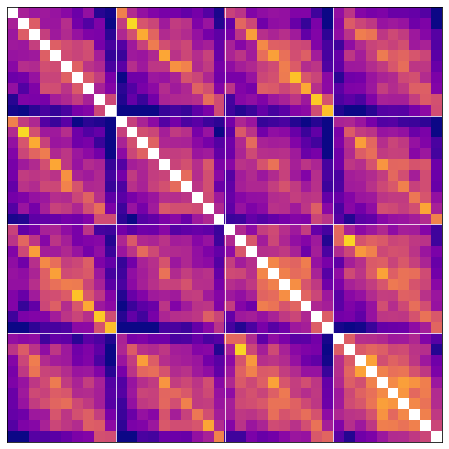

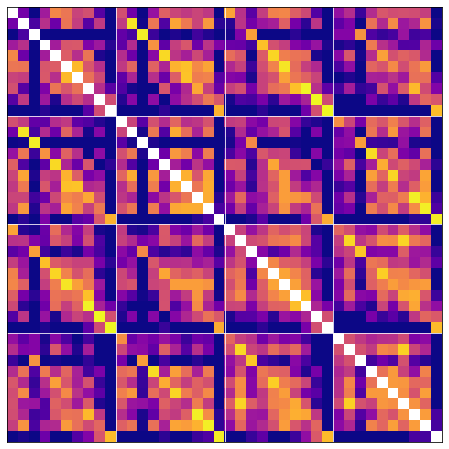

In [22]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1
RDM_LAYER = "state_encoder"
RDM_PLOTS_AGENTS = [
    # Gen 1
    "ppo_bc__rgb_spectro__gru__SAVi",

    "ppo_bc__rgb_spectro__pgwt__SAVi",

    # Gen 2
    ## Baseline
    # "ppo_bc__rgb_spectro__gru2__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",

    ## GWT variants
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu",
]

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

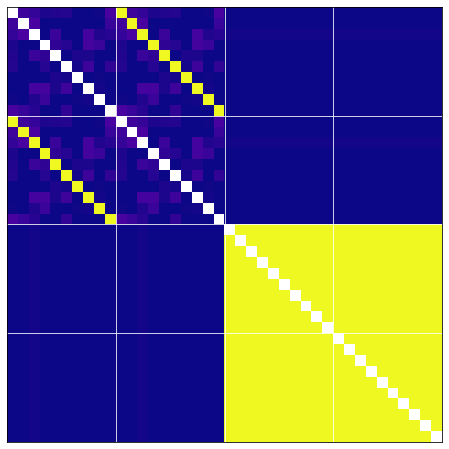

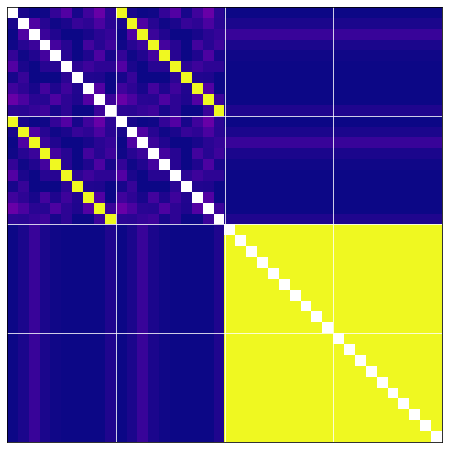

In [23]:
RDM_LAYER = "visual_encoder.cnn.7"

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

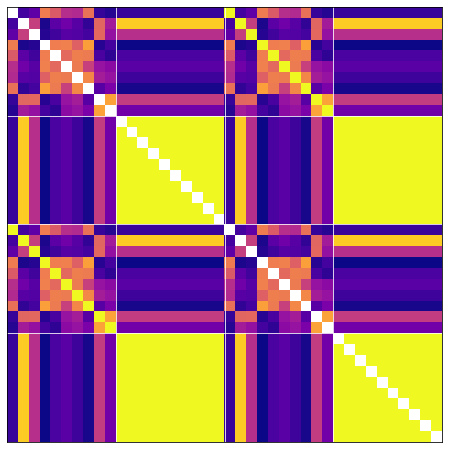

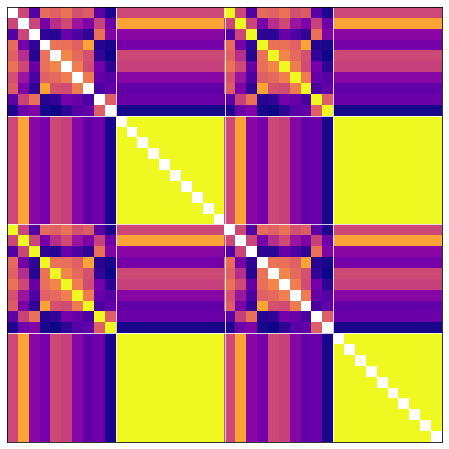

In [24]:
RDM_LAYER = "audio_encoder.cnn.7"

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

In [28]:
# Prototype to recover the avg step-to-step features similarity
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1
RDM_LAYER = "state_encoder"
RDM_PLOTS_AGENTS = [
    "ppo_bc__rgb_spectro__gru__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",

    "ppo_bc__rgb_spectro__pgwt__SAVi",

    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu",
]

AGENT_AVG_SIMIES = {}

for agnt in RDM_PLOTS_AGENTS:
    mean, std = get_cross_ablation_sim_mean_std(
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,\
        "rsa_correlation_sim",
        "all",
        "vis_aud"
    )
    AGENT_AVG_SIMIES[agnt] = mean

# print(AGENT_AVG_SIMIES)
from pprint import pprint
pprint(AGENT_AVG_SIMIES)

{'ppo_bc__rgb_spectro__gru__SAVi': 0.4859089106321335,
 'ppo_bc__rgb_spectro__pgwt__SAVi': 0.6350030213594436}


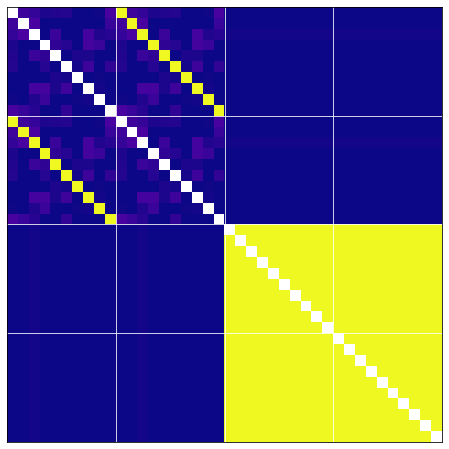

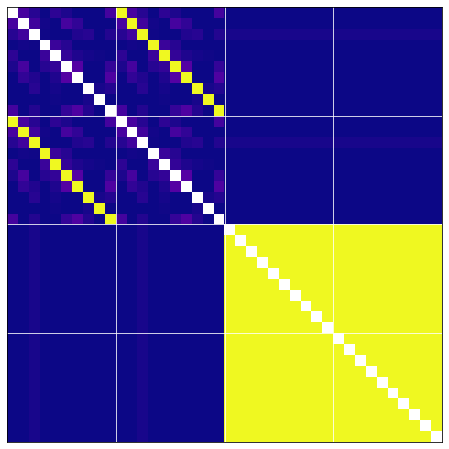

In [20]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1
RDM_LAYER = "visual_encoder.cnn.7"
RDM_PLOTS_AGENTS = [
    "ppo_bc__rgb_spectro__gru__SAVi",
    "ppo_bc__rgb_spectro__gru2__SAVi"

    # "ppo_bc__rgb_spectro__pgwt__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",
]

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

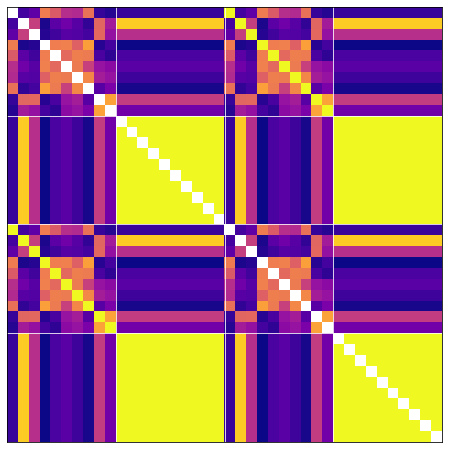

In [21]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1
RDM_LAYER = "audio_encoder.cnn.7"
RDM_PLOTS_AGENTS = [
    "ppo_bc__rgb_spectro__gru__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi"

    # "ppo_bc__rgb_spectro__pgwt__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",
]

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

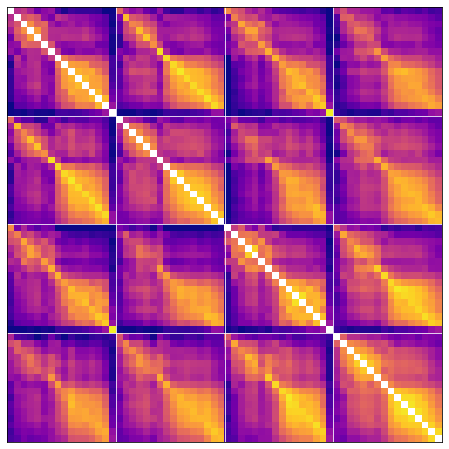

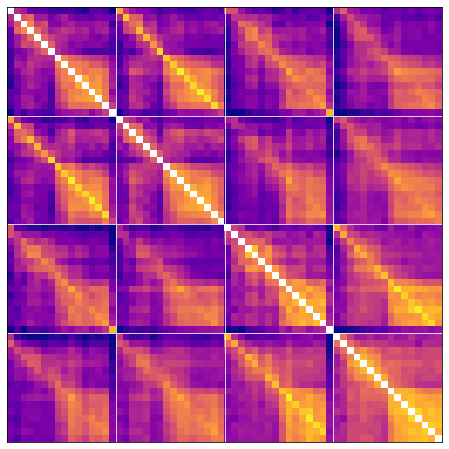

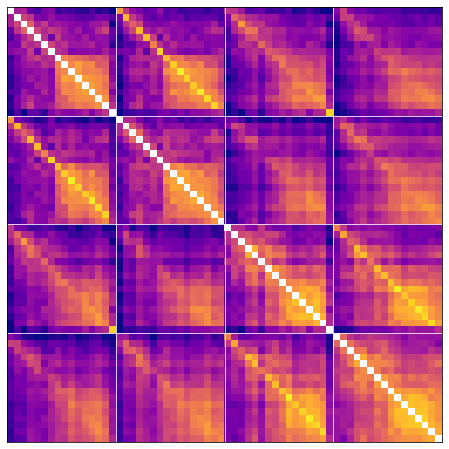

In [22]:
RDM_CAT = "table"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 0
RDM_LAYER = "state_encoder"
RDM_PLOTS_AGENTS = [
    # "ppo_bc__rgb_spectro__gru__SAVi",
    "ppo_bc__rgb_spectro__gru2__SAVi",

    # "ppo_bc__rgb_spectro__pgwt__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",

    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu"
]

for agnt in RDM_PLOTS_AGENTS:
    plot_rdm(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
        RDM_CAT,
        RDM_SCENE,
        RDM_TRAJ_IDX,
        agnt,
        RDM_LAYER,
        "rsa_correlation_sim",
        "all"
    )

In [23]:
# plot_rdm(
#     CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
#     CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
#     "chair",
#     "gTV8FGcVJC9",
#     1,
#     "ppo_bc__rgb_spectro__gru__SAVi",
#     "state_encoder",
#     "rsa_correlation_sim",
#     "default"
# )

# plot_rdm(
#     CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
#     CAT_SCENE_TRAJ_AGENTS_LAYERS_ABLATIONS_RDMS,
#     "chair",
#     "gTV8FGcVJC9",
#     1,
#     "ppo_bc__rgb_spectro__pgwt__SAVi",
#     "state_encoder",
#     "rsa_correlation_sim",
#     "default"
# )

## Compute RDMs / Sparsities related features for cross-agent comparisons
- For the same trajectories, computes RSA metrics for multiple agents at the same time, then use it to compare with each other

In [24]:
# # NOTE: Takes around 40 minutes to proccess 6 categories -> 5 scenes -> 5 trajectories -> 4 ablation types -> 4 agent variant
# NOTE: This variant coputes the features over various ablation independently

LAYERS_OF_INTEREST = [
    "state_encoder",
    "visual_embedding", "audio_embedding",
    "visual_encoder.cnn.7", "audio_encoder.cnn.7", "visual_encoder.linear.1"
]

CROSS_AGENTS_OF_INTEREST = [
    # "ppo_bc__rgb_spectro__gru__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",
    # "ppo_bc__rgb_spectro__pgwt__SAVi"

    ## GWT v2 BU TD variants
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu"
]

CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS = {
    k: {
        kk: {
            traj_idx: {
                layer: {} for layer in LAYERS_OF_INTEREST
            } for traj_idx, traj_data in vv.items()
        } for kk, vv in v.items()
    } for k, v in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items()
}

# Process the features and compute the RDMs data, sparsities, etc...
for catname, cat_data in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.items():
    print(f"{catname}:")

    for scene, scene_data in cat_data.items():
        # For plot and data caching
        # scene_dirname = f"{cat_dirname}/{scene}"

        # traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}:")

        for traj_idx, traj_data in scene_data.items():
            # if traj_idx not in TRAJS_OF_INTEREST:
            #     continue
            print(f"    Traj {traj_idx}:")

            for layer in LAYERS_OF_INTEREST:
                layers_agents_crossanal_feats = []

                print(f"        {layer}:")

                for agent, agent_data in traj_data.items():
                    if agent in ["target_scene_idx_list", "target_category_idx_list"]:
                        continue
                    
                    if agent not in CROSS_AGENTS_OF_INTEREST:
                        continue # Skip in case it is not in the list of agents of interest

                    if layer not in list(agent_data.keys()):
                        continue # Skip the layer in case it is not present in the agent structure
                    
                    # Default
                    features = agent_data[layer]
                    if layer == "visual_encoder.cnn.7" and agent.__contains__("rec_rgb_vis_ae_5"):
                        # Special override of layer name across agent to match visual features
                        features = agent_data["visual_encoder.linear.1"]

                    # Compute RDM for all the ablation types concatenated
                    if (agent.__contains__("gru") or agent.__contains__("pgwt")) \
                        and layer in ["state_encoder"]:
                        # Skip the reshape state_features vector required for SS1.0 backward compat.
                        features = features[0]
                    
                    print(f"          {agent}: {[len(features), *features[0].shape]}")

                    # Compute the RDM for this layer for all ablation types
                    if features.dim() == 3:
                        pass
                    elif features.dim() == 4:
                        raise NotImplementedError(f"features with dim == 4 not supported ?")
                    elif features.dim() == 5:
                        features = features.reshape(*features.shape[:2], -1)
                    D = features[0].shape[-1]

                    # default_abl_feats = [features[t][0].numpy() for t in range(len(features))] # [T, D]
                    
                    layers_agents_crossanal_feats.append(features[:, 0, :].numpy())
                
                layers_agents_crossanal_feats = np.array(layers_agents_crossanal_feats, dtype=np.float32).reshape(-1, D)

                if len(layers_agents_crossanal_feats) == 0:
                    continue # In case the layer has empty feature list, then skip it

                for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
                    # print(f"            {dissm_metric}:")
                    rdm_data = rsatoolbox.data.Dataset(layers_agents_crossanal_feats)
                    rdm_itself = dissim_metric_data["fn"](rdm_data)
                        
                    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS[catname][scene][traj_idx][layer][dissm_metric] = rdm_itself

chair:
  gTV8FGcVJC9:
    Traj 0:
        state_encoder:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [28, 4, 512]
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu: [28, 4, 512]
        visual_embedding:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [28, 4, 512]
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu: [28, 4, 512]
        audio_embedding:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [28, 4, 512]
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu: [28, 4, 512]
        visual_encoder.cnn.7:
        audio_encoder.cnn.7:
        visual_encoder.linear.1:
    Traj 1:
        state_encoder:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [10, 4, 512]
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu: [10, 4, 512]
        visual_embedding:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [10, 4, 512]
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu: [10, 4, 512]
        audio_embedding:
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td: [10, 4, 512]
          ppo_bc__savi_ss

In [25]:
def plot_rdm_crossagent(
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
        CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
        catname,
        scene,
        traj_idx,
        layer,
        dissim_metric,
        # ablation="all"
    ):
    # Recover the traj_lengths
    traj_length = len(CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx]["target_scene_idx_list"])
    tmp_rdm = CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS[catname][scene][traj_idx][layer][dissim_metric]

    return rsatoolbox.vis.rdm_plot.show_rdm(tmp_rdm, figsize=(8, 8), cmap="plasma", num_pattern_groups=traj_length, vmin=0, vmax=1.0)

(<Figure size 576x576 with 1 Axes>,
 array([[<AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:>: {'image': <matplotlib.image.AxesImage at 0x7f7dc03f4bb0>}}))

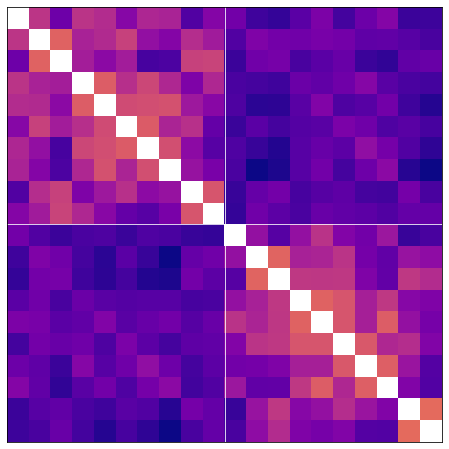

In [26]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1

plot_rdm_crossagent(
    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
    RDM_CAT,
    RDM_SCENE,
    RDM_TRAJ_IDX,
    "state_encoder",
    "rsa_correlation_sim"
)

In [27]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1

plot_rdm_crossagent(
    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
    RDM_CAT,
    RDM_SCENE,
    RDM_TRAJ_IDX,
    "visual_encoder.cnn.7",
    "rsa_correlation_sim"
)

plot_rdm_crossagent(
    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
    RDM_CAT,
    RDM_SCENE,
    RDM_TRAJ_IDX,
    "visual_encoder.cnn.7",
    "rsa_correlation_sim"
)

KeyError: 'rsa_correlation_sim'

In [ ]:
RDM_CAT = "chair"
RDM_SCENE = "gTV8FGcVJC9"
RDM_TRAJ_IDX = 1

plot_rdm_crossagent(
    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
    RDM_CAT,
    RDM_SCENE,
    RDM_TRAJ_IDX,
    "audio_encoder.cnn.7",
    "rsa_correlation_sim"
)

plot_rdm_crossagent(
    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES,
    CAT_SCENE_TRAJ_LAYERS_CROSS_AGENTS_RDMS,
    RDM_CAT,
    RDM_SCENE,
    RDM_TRAJ_IDX,
    "audio_encoder.cnn.7",
    "rsa_correlation_sim"
)

KeyError: 'rsa_correlation_sim'

# Saliency map computation

In [86]:
# Precompute baseline values for non-zeros occlusion method
# TODO: consider caching this
# TODO: consider storing as numpy, then copying to torch.device only when needs be
CAT_SCENE_TRAJS_OCCLUSION_BASELINES = {}

for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
    print(f"{catname}:")
    if catname not in CAT_SCENE_TRAJS_OCCLUSION_BASELINES.keys():
        CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname] = {}

    for scene, scene_trajs in cat_scenes_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
        print(f"  {scene}: {traj_lengths}")

        if scene not in CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname].keys():
            CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene] = {}

        for traj_idx, traj_data in enumerate(scene_trajs):
            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True)
            
            for t, obs_dict in enumerate(obs_dict_list):
                for k, v in obs_dict.items():
                    # if k not in ["rgb", "depth", "spectrogram"]:
                    if k not in ["rgb", "depth", "spectrogram"]:
                        continue    
                    if k not in CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene].keys():
                        CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene][k] = []
                    
                    CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene][k].append(v)

        for k, v in CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene].items():
            CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene][k] = \
                th.stack(v).mean(dim=0)

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]
  b8cTxDM8gDG: [15, 19, 26, 20, 8]
  D7N2EKCX4Sj: [19, 36, 12, 40, 33]
  Vvot9Ly1tCj: [18, 21, 23, 16, 27]
  vyrNrziPKCB: [20, 24, 10, 14, 28]
picture:
  gTV8FGcVJC9: [10, 12, 16, 20, 17]
  D7N2EKCX4Sj: [46, 31, 53, 39, 43]
  vyrNrziPKCB: [12, 38, 18, 14, 15]
  Vvot9Ly1tCj: [24, 51, 31, 41, 35]
  b8cTxDM8gDG: [33, 12, 13, 20, 11]
table:
  vyrNrziPKCB: [22, 22, 54, 57, 12]
  b8cTxDM8gDG: [17, 9, 16, 25, 14]
  D7N2EKCX4Sj: [6, 31, 24, 28, 17]
  Vvot9Ly1tCj: [23, 41, 14, 34, 32]
  gTV8FGcVJC9: [16, 13, 15, 18, 15]
cushion:
  b8cTxDM8gDG: [7, 14, 22, 12, 8]
  Vvot9Ly1tCj: [36, 32, 47, 36, 46]
  vyrNrziPKCB: [62, 18, 21, 42, 54]
  gTV8FGcVJC9: [10, 11, 27, 7, 13]
  D7N2EKCX4Sj: [21, 12, 14, 14, 20]
cabinet:
  gTV8FGcVJC9: [13, 13, 18, 47, 13]
  vyrNrziPKCB: [30, 22, 22, 40, 47]
  b8cTxDM8gDG: [10, 14, 21, 24, 16]
  Vvot9Ly1tCj: [9, 35, 42, 39, 28]
  D7N2EKCX4Sj: [21, 34, 14, 40, 10]
plant:
  gTV8FGcVJC9: [6, 13, 42, 6, 41]
  Vvot9Ly1tCj: [16, 47, 23,

In [87]:
# plt.imshow(CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname]["gTV8FGcVJC9"]["rgb"][0].int())
# .shape

## Actual computation of Sal. maps

### Occlusion realted helpers

In [88]:
def apply_occlusion_obs_dict_list(obs_dict_list, occ_step, occ_type="zeros", occ_target="rgb", occ_baseline_dict=None, device="cpu"):
    # Support "rgb", "depth", and "spectrogram" fields so far

    # NOTE: The following is uneeded, but just kept as reference
    if occ_target in ["rgb", "depth"]:
        H, W = 128, 128
    elif occ_target in ["spectrogram"]:
        H, W = 65, 26
    else:
        raise NotImplementedError(f"Unsupported occlusion for occ_target: {occ_target}")

    occluded_obs_dict_list = []
    occlusion_mask_dict_list = []

    ep_length = len(obs_dict_list)

    for t in range(ep_length):
        occluded_obs_dict = {k: [v] for k, v in obs_dict_list[t].items()}
        occlusion_mask_dict = {k: [th.zeros_like(v)] for k, v in obs_dict_list[t].items()}

        for k, v in obs_dict_list[t].items():
            for m in range(occ_step, H + occ_step, occ_step):
                for n in range(occ_step, W + occ_step, occ_step):

                    # TODO: improve the logic for better 
                    # if k == occ_target:
                    #   if k is either "rgb", or "spectrogram":
                    #       apply occlusion
                    # else:
                    #   copy the value of the k field as is
                    
                    if k in ["rgb", "spectrogram"] and k == occ_target:
                        # rgb_obs = copy.deepcopy(v)
                        rgb_obs = v
                        occ_mask = th.zeros_like(rgb_obs)
                        occ_mask[0, m-occ_step:m, n-occ_step:n, :] = 1

                        if occ_type == "zeros":
                            occ_data = th.zeros_like(rgb_obs)
                        elif occ_type == "avg_baseline":
                            occ_data = occ_baseline_dict[k].to(device)
                        
                        occ_rgb_obs = th.where(occ_mask.bool(), occ_data, rgb_obs)
                        
                        occluded_obs_dict[k].append(occ_rgb_obs)
                        occlusion_mask_dict[k].append(occ_mask)
                    else:
                        occ_mask = th.zeros_like(v)

                        # occluded_obs_dict[k].append(copy.deepcopy(v))
                        occluded_obs_dict[k].append(v)
                        occlusion_mask_dict[k].append(occ_mask)
        
        occluded_obs_dict_list.append({kk: th.cat(vv) for kk, vv in occluded_obs_dict.items()})
        occlusion_mask_dict_list.append({kk: th.cat(vv) for kk, vv in occlusion_mask_dict.items()})

        th.cuda.empty_cache()

    # "occluded_obs_dict_list"'s index 0 is the non occluded image
    # Length: 1 + number of occluded obs, number of occ. obs
    return occluded_obs_dict_list, occlusion_mask_dict_list

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw__occ_variant(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.stack(v, dim=0).cpu()
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.stack(vv, dim=0).cpu() for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

# occluded_obs_dict_list, occlusion_mask_dict_list = apply_occlusion_obs_dict_list(obs_dict_list, occ_step=32)

In [96]:
# Cache config
SALMAP_CACHE_DIRNAME = f"cached_data/saliency_maps/{analysis_trajs_filename.split('.')[0]}"
if not os.path.exists(SALMAP_CACHE_DIRNAME):
    os.makedirs(SALMAP_CACHE_DIRNAME, exist_ok=True)

ALL_SALIENCIES = None

# Config of the analysis
# OCC_TARGETS = ["rgb", "spectrogram"] # All: ["rgb", "spectrogram"]
OCC_TARGETS = ["rgb", "spectrogram"] # All: ["rgb", "spectrogram"]
CATEGORIES_OF_INTEREST = [
    # "chair",
    # "picture",
    # "cushion"
    # "table",
    "plant",
] # All: ["plant", "chair", "table", "cushion", "cabinet", "picture"]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9"
] # All: ["gTV8FGcVJC9", "D7N2EKCX4Sj", "vyrNrziPKCB", "Vvot9Ly1tCj", "b8cTxDM8gDG"]

TRAJS_OF_INTEREST = [
    0, 
    1,
    2,
    3,
    4
]

# New GWT BU+TD or just BU / TD variants
LAYERS_OF_INTEREST = [
    "state_encoder",
    "visual_embedding", "audio_embedding",
    "visual_encoder.cnn.7", "audio_encoder.cnn.7"
]

OCCLUSION_TYPES = ["avg_baseline"] # Default: ["zeros", "avg_baseline"]

OCC_TARGET_STEPS = {
    "rgb": 8,
    "spectrogram": 2
}

In [97]:
import datetime
GEN_TIMESTAMP = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

ALPHA = 0.2 # For saliency maps plots

# Helpers
def scale_values(a, old_min=0, old_max=1, new_min=-1, new_max=1):
    return ((a - old_min) * (new_max - new_min)) / (old_max - old_min + 1e-8) + new_min

# Caching if not already exisitng
# If it does exist, then consider just skip the whole computation loop
allsall_filename = f"{SALMAP_CACHE_DIRNAME}/all_saliencies.{GEN_TIMESTAMP}.bz2"

# Placeholder for all saliencyes
ALL_SALIENCIES = {
    k: {
        kk: {
            kkk: {
                occ_target: {
                    occ_type: {
                        agent_variant: {} \
                            for agent_variant in MODEL_VARIANTS_TO_AGENTMODEL.keys()
                    } for occ_type in OCCLUSION_TYPES
                } for occ_target in OCC_TARGETS
            } for kkk in range(len(vv))
        } for kk, vv in v.items()
    } for k, v in cats_scenes_trajs_dict.items()
} # Holds all the saliencies computed

if not os.path.exists(allsall_filename):
    for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
        # Skip categories that are not of interest
        if catname not in CATEGORIES_OF_INTEREST:
            continue
        print(f"{catname}:")
        
        # For plot and data caching
        cat_dirname = f"{SALMAP_CACHE_DIRNAME}/saliencies_data/{GEN_TIMESTAMP}/{catname}"

        for scene, scene_trajs in cat_scenes_trajs.items():
            # Skip scenes that are not of interest
            if scene not in SCENES_OF_INTEREST:
                continue
            
            # For plot and data caching
            scene_dirname = f"{cat_dirname}/{scene}"

            traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
            print(f"  {scene}: {traj_lengths}")

            for traj_idx, traj_data in enumerate(scene_trajs):
                if traj_idx not in TRAJS_OF_INTEREST:
                    continue
                print(f"    Traj {traj_idx}")

                # For plot and data caching
                traj_dirname = f"{scene_dirname}/{traj_idx}"

                # Load the current trajectory's data
                obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                    get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
                
                traj_length = len(obs_dict_list)

                # Iterate over the observation fields to analyze using occlusion and sal. maps
                for occ_target in OCC_TARGETS:
                    print(f"      Occlusion target: {occ_target}")

                    # For plot and data caching
                    occ_target_dirname = f"{traj_dirname}/{occ_target}"

                    # Iterate over the occlusion types
                    for occ_type in OCCLUSION_TYPES:
                        print(f"        Occlusion type: {occ_type}")
                        # For plot and data caching
                        occ_type_dirname = f"{occ_target_dirname}/{occ_type}"

                        if occ_type == "zeros":
                            occluded_obs_dict_list, occlusion_mask_dict_list = apply_occlusion_obs_dict_list(
                                obs_dict_list, 
                                occ_step=OCC_TARGET_STEPS[occ_target],
                                device=dev # size of the sliding occlusion window
                            )
                        elif occ_type == "avg_baseline":
                            occ_baseline_dict = CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene]
                            occluded_obs_dict_list, occlusion_mask_dict_list = apply_occlusion_obs_dict_list(
                                obs_dict_list,
                                occ_target=occ_target,
                                occ_step=OCC_TARGET_STEPS[occ_target],
                                occ_type=occ_type,
                                occ_baseline_dict=occ_baseline_dict,
                                device=dev
                            )
                        else:
                            raise NotImplementedError(f"Unsupported occlusion type: {occ_type}")
                    
                        # Origianl image + occluded image (== H // occ_step)
                        B = occluded_obs_dict_list[0]["rgb"].shape[0]

                        for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                            if agent_variant in ["ppo_gru__random", "ppo_pgwt__random"]:
                                # Skip irrelevant variants
                                continue
                            print(f"          Model variant: {agent_variant}")

                            # For plot and data caching
                            agent_variant_dirname = f"{occ_type_dirname}/{agent_variant}"

                            agent_raw_features = {}
                            # NOTE: Do we really need to keep this in a dictionary ?
                            if agent_variant.__contains__("gru") or \
                                agent_variant.__contains__("gwt_bu_td") or \
                                agent_variant.__contains__("gwt_bu") or \
                                agent_variant.__contains__("gwt_td"):
                                agent_rnn_state = th.zeros((1, B, args.hidden_size), device=dev)
                            elif agent_variant.__contains__("pgwt"):
                                agent_rnn_state = agent_model.state_encoder.latents.clone().repeat(B, 1, 1)

                            for t, (obs_th, done_th) in enumerate(zip(occluded_obs_dict_list, done_list)):
                                masks = 1. - done_th[:, None].repeat(B, 1)

                                with th.no_grad():
                                    _, _, _, _, _, _, agent_rnn_state, _ = \
                                        agent_model.act(obs_th, agent_rnn_state, masks)

                                # Collecting intermediate layers results
                                for k, v in agent_model._features.items():
                                    if k not in LAYERS_OF_INTEREST:
                                        continue # Skip irrelevant layers
                                    if k not in list(agent_raw_features.keys()):
                                        agent_raw_features[k] = []
                                    agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                                
                                # agent_rnn_state of shape [1, 1+n_input_locs, H]
                                # We thus need to copy the rnn_state at step 0 to steps 1:n_input_locs+1 indeed
                                if agent_variant.__contains__("gwt_bu_td") or \
                                    agent_variant.__contains__("gwt_bu") or \
                                    agent_variant.__contains__("gwt_td"):
                                    agent_rnn_state[1:, :] = agent_rnn_state[0, :][None, :].repeat(B-1, 1)
                                elif agent_variant.__contains__("gru"):
                                    agent_rnn_state[:, 1:, :] = agent_rnn_state[:, 0, :][:, None, :].repeat(1, B-1, 1)
                                elif agent_variant.__contains__("pgwt"):
                                    agent_rnn_state[1:, :, :] = agent_rnn_state[0, :, :][None, :, :].repeat(B-1, 1, 1)
                            
                            agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
                            del agent_raw_features
                            # TODO: store the features: agent_layers_features ?

                            # Compute the saliency for each intermediate layer of interest of the agent variant
                            for intermediate_layer, traj_occlusions_features in agent_layers_features.items():
                                print(f"            Compute saliencies for layer: {intermediate_layer}")
                                if intermediate_layer in ["state_encoder"]:
                                    if agent_variant.__contains__("gwt_bu_td") or \
                                       agent_variant.__contains__("gwt_bu") or \
                                       agent_variant.__contains__("gwt_td"):
                                        # Do nothing because we are using custom GRUCell instead of SS baselines'
                                        # The latter actually returns two vectors of shape [B, H], [1, B, H] for compatiblity reasons
                                        pass
                                    else:
                                        traj_occlusions_features = traj_occlusions_features[0]

                                # For plot and data caching
                                layer_dirname = f"{agent_variant_dirname}/{intermediate_layer}"

                                n_input_locs = traj_occlusions_features.shape[1] - 1 # How mnay occlusion "centers"
                                traj_layer_saliencies = []

                                for t in range(traj_length):
                                    no_occ_features = traj_occlusions_features[t][0]
                                    occ_saliencies = []

                                    for i in range(1, 1+n_input_locs):
                                        i_occ_saliency = (no_occ_features - traj_occlusions_features[t][i]).norm(2)
                                        occ_saliencies.append(i_occ_saliency.item())
                                    traj_layer_saliencies.append(occ_saliencies)
                                
                                saliencies = traj_layer_saliencies = np.array(traj_layer_saliencies)

                                # Store for later usage:
                                ALL_SALIENCIES[catname][scene][traj_idx][occ_target][occ_type][agent_variant][intermediate_layer] = \
                                    traj_layer_saliencies
                                
                                # Individual cache file
                                os.makedirs(layer_dirname, exist_ok=True)
                                layercache_filename = f"{layer_dirname}/saliencies.bz2"

                                if not os.path.exists(layercache_filename):
                                    with open(layercache_filename, "wb") as f:
                                        cpkl.dump(traj_layer_saliencies, f)
                                
                                # Generate plot, save to disk
                                # Scale the saliencies over all the values in the given trajectory
                                traj_saliency_min, traj_saliency_max = saliencies.min(), saliencies.max()
                                
                                scaled_saliencies = scale_values(saliencies, traj_saliency_min, traj_saliency_max, 0.0, 1.0)
                                n_input_locs = B - 1

                                fig, axes = plt.subplots(1, traj_length, figsize=(traj_length * 6, 6 + 1.5))

                                # Get min and max of spectrograms values across a single trajectory
                                traj_spect = np.array([occluded_obs_dict_list[t]["spectrogram"][0].cpu().numpy() for t in range(traj_length)])
                                spectr_min, spectr_max = traj_spect.min(), traj_spect.max()

                                for t, (obs_dict, obs_occ_mask) in enumerate(zip(occluded_obs_dict_list, occlusion_mask_dict_list)):
                                    # Plot the default image
                                    # NOTE: the [0] indexing in [OCC_TARGET][0] is because we store the non-occluded image at that positon
                                    # All the other indices 1: have different occlusion variants
                                    if occ_target == "rgb":
                                        img_data = obs_dict[occ_target][0].cpu().numpy().astype(np.uint8)
                                        axes[t].imshow(img_data)
                                    elif occ_target == "spectrogram":
                                        img_data = th.cat([obs_dict[occ_target][0][:, :, i] for i in range(2)], dim=1).cpu().numpy()
                                        img_data = scale_values(img_data, old_min=spectr_min, old_max=spectr_max, new_min=0., new_max=1.)
                                        axes[t].imshow(img_data, cmap="gray")
                                    else:
                                        raise NotImplementedError(f"Unsupported input data for saliency map: {occ_target}")
                                    
                                    axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
                                    axes[t].set_title(f"t = {t}", fontsize=20)

                                    # Generated mask based on saliencies
                                    saliency_mask = np.zeros_like(obs_dict[occ_target][0].cpu().numpy(), dtype=np.float32)
                                    
                                    for i in range(1, n_input_locs+1):
                                        i_occ_mask = obs_occ_mask[occ_target][i].cpu().numpy()
                                        saliency_mask = np.where(i_occ_mask, scaled_saliencies[t][i-1], saliency_mask)
                                    
                                    if occ_target == "rgb":
                                        saliency_mask = saliency_mask[:, :, 0]
                                    elif occ_target == "spectrogram":
                                        saliency_mask = np.concatenate([saliency_mask[:, :, i] for i in range(2)], 1)
                                    
                                    axes[t].imshow(saliency_mask, alpha=ALPHA, cmap="jet", vmin=0.0, vmax=1.0)
                                    # print(t)
                                    # print(obs_dict["rgb"].shape)
                                    # print(f"            {obs_occ_mask['rgb'].shape}")
                                
                                fig.suptitle(f"Saliency map for cat: {catname} | Scene: {scene} | Occ. target: {occ_target} | Occ. type: {occ_type} | Traj: {traj_idx} | {agent_variant} | {intermediate_layer} ", fontsize=28)
                                fig.tight_layout()

                                # Save to file
                                salmap_plot_dirname = f"{SALMAP_CACHE_DIRNAME}/saliencies_plots/{GEN_TIMESTAMP}/" + \
                                    f"{catname}/{scene}/{traj_idx}/{occ_target}/{occ_type}/{agent_variant}/{intermediate_layer}"
                                os.makedirs(salmap_plot_dirname, exist_ok=True)
                                salmap_plot_filename = f"{salmap_plot_dirname}/salmap_plot.png"
                                fig.savefig(salmap_plot_filename)
                                plt.close(fig)
                            
                            # Cleanup
                            del agent_layers_features, agent_rnn_state
                            th.cuda.empty_cache() # Clear up GPU cache that gets quite high

                        # Clean up:
                        del occluded_obs_dict_list, occlusion_mask_dict_list
                        th.cuda.empty_cache() # Clear up GPU cache that gets quite high
                
                del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
                th.cuda.empty_cache() # Clear up GPU cache that gets quite high
                
                # break # traj_idx ; debug mostly

            # break # scene ; debug mostly

        # break # category ; debug mostly
    
    # Cache to disk in case the file is not detected
    if not os.path.exists(allsall_filename):
        with open(allsall_filename, "wb") as f:
            cpkl.dump(ALL_SALIENCIES, f)

plant:
  gTV8FGcVJC9: [6, 13, 42, 6, 41]
    Traj 0
      Occlusion target: rgb
        Occlusion type: avg_baseline


          Model variant: ppo_bc__rgb_spectro__gru__SAVi
            Compute saliencies for layer: visual_encoder.cnn.7
            Compute saliencies for layer: audio_encoder.cnn.7
            Compute saliencies for layer: state_encoder
          Model variant: ppo_bc__rgb_spectro__pgwt__SAVi
            Compute saliencies for layer: visual_encoder.cnn.7
            Compute saliencies for layer: audio_encoder.cnn.7
            Compute saliencies for layer: state_encoder
          Model variant: ppo_bc__rgb_spectro__gru2__SAVi
            Compute saliencies for layer: visual_encoder.cnn.7
            Compute saliencies for layer: audio_encoder.cnn.7
            Compute saliencies for layer: state_encoder
          Model variant: ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5
            Compute saliencies for layer: visual_encoder.cnn.7
            Compute saliencies for layer: audio_encoder.cnn.7
            Compute saliencies for layer: state_encoder
          Model variant: ppo_bc

## Saliency maps plottings

plant:
  gTV8FGcVJC9:
    Traj #4 | Len: 41
      Occlusion target: rgb


        Occlusion type: avg_baseline
          ppo_bc__rgb_spectro__gru__SAVi
            state_encoder:
          ppo_bc__rgb_spectro__pgwt__SAVi
            state_encoder:
          ppo_bc__rgb_spectro__gru2__SAVi
          ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu
      Occlusion target: spectrogram
        Occlusion type: avg_baseline
          ppo_bc__rgb_spectro__gru__SAVi
            state_encoder:
          ppo_bc__rgb_spectro__pgwt__SAVi
            state_encoder:
          ppo_bc__rgb_spectro__gru2__SAVi
          ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
          ppo_bc__savi_ss1_rgb_spectro__gwt_bu


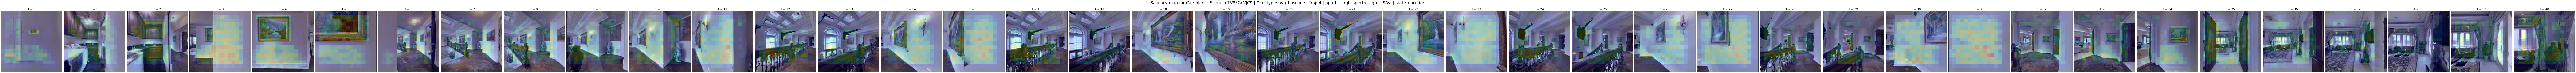

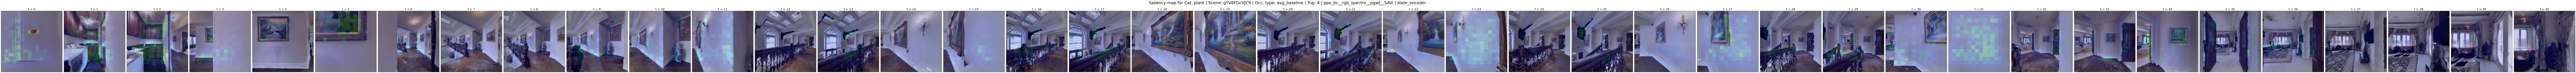

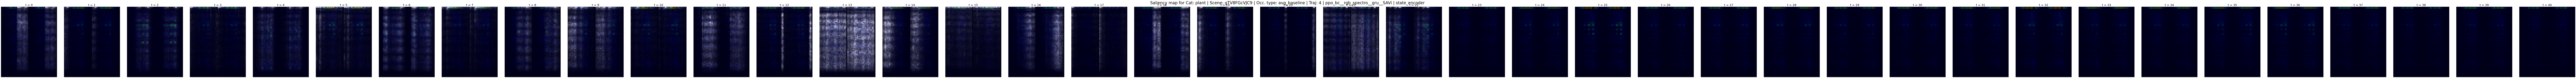

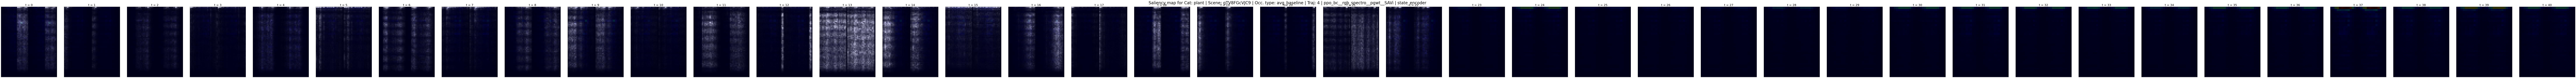

In [134]:
if ALL_SALIENCIES is None:
    with open(allsall_filename, "rb") as f:
        ALL_SALIENCIES = cpkl.load(f)

ALPHA = 0.2

# dev = th.device("cpu")
dev = th.device("cuda")

# CATEGORIES_OF_INTEREST = ["chair"]
# Config of the analysis
OCC_TARGETS = ["rgb", "spectrogram"] # All: ["rgb", "spectrogram"]
# CATEGORIES_OF_INTEREST = ["chair", "picture", "table", "cushion", "cabinet", "plant"] # All: ["plant", "chair", "table", "cushion", "cabinet", "picture"]
CATEGORIES_OF_INTEREST = [
    # "chair",
    # "picture",
    # "cushion",
    # "table",
    "plant",
] # All: ["plant", "chair", "table", "cushion", "cabinet", "picture"]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9"
] # All: ["gTV8FGcVJC9", "D7N2EKCX4Sj", "vyrNrziPKCB", "Vvot9Ly1tCj", "b8cTxDM8gDG"]


AGENT_VARIANTS_OF_INTEREST = [
    # Gen 1
    "ppo_bc__rgb_spectro__gru__SAVi",
    "ppo_bc__rgb_spectro__pgwt__SAVi",
    
    # Gen 2
    
    ## GRU2 baseline
    # "ppo_bc__rgb_spectro__gru2__SAVi",
    # "ppo_bc__rgb_spectro__gru2__SAVi__rec_rgb_vis_ae_5",
    
    ## GWT variants
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_bu",
    # "ppo_bc__savi_ss1_rgb_spectro__gwt_td"
]

TRAJS_OF_INTEREST = [
    # 0,
    # 1,
    # 2,
    # 3,
    4
]

# New GWT BU+TD or just BU / TD variants
LAYERS_OF_INTEREST = [
    "state_encoder", 
    # "visual_embedding", "audio_embedding", 
    # "visual_encoder.cnn.7", "audio_encoder.cnn.7"
]

# Helpers
def scale_values(a, old_min=0, old_max=1, new_min=-1, new_max=1):
    return ((a - old_min) * (new_max - new_min)) / (old_max - old_min + 1e-8) + new_min

for catname, scene_trajs_occ_agentvariant_saliencies in ALL_SALIENCIES.items():
    if catname not in CATEGORIES_OF_INTEREST:
        continue
    
    # Folder structure to save the file
    print(f"{catname}:")

    for scene, trajs_occ_agentvariant_saliencies in scene_trajs_occ_agentvariant_saliencies.items():
        if scene not in SCENES_OF_INTEREST:
            continue
        
        print(f"  {scene}:")

        for traj_idx, occtarg_occtype_agentvariant_saliencies in trajs_occ_agentvariant_saliencies.items():
            if traj_idx not in TRAJS_OF_INTEREST:
                continue
            
            # Load the data, perform ablations if necessary
            obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)

            traj_length = len(obs_dict_list)
            print(f"    Traj #{traj_idx} | Len: {traj_length}")

            # if traj_length > 20:
            #     continue
            
            # Iterate over the observation fields to analyze using occlusion and sal. maps
            for occ_target, occtype_agentvar_layers_saliencies in occtarg_occtype_agentvariant_saliencies.items():
                if occ_target not in OCC_TARGETS:
                    continue

                print(f"      Occlusion target: {occ_target}")

                # Iterate over the occlusion types
                for occ_type, agentvar_layers_saliencies in occtype_agentvar_layers_saliencies.items():
                    if occ_type == "zeros":
                        occluded_obs_dict_list, occlusion_mask_dict_list = apply_occlusion_obs_dict_list(
                            obs_dict_list, 
                            occ_step=OCC_TARGET_STEPS[occ_target],
                            device=dev # size of the sliding occlusion window
                        )
                    elif occ_type == "avg_baseline":
                        occ_baseline_dict = CAT_SCENE_TRAJS_OCCLUSION_BASELINES[catname][scene]
                        occluded_obs_dict_list, occlusion_mask_dict_list = apply_occlusion_obs_dict_list(
                            obs_dict_list,
                            occ_target=occ_target,
                            occ_step=OCC_TARGET_STEPS[occ_target],
                            occ_type=occ_type,
                            occ_baseline_dict=occ_baseline_dict,
                            device=dev
                        )
                    else:
                        raise NotImplementedError(f"Unsupported occlusion type: {occ_type}")
                    print(f"        Occlusion type: {occ_type}")

                    # Origianl image + occluded image (== H // occ_step)
                    B = occluded_obs_dict_list[0]["rgb"].shape[0]
                    
                    for agent_variant, layer_saliencies in agentvar_layers_saliencies.items():
                        if agent_variant in ["ppo_gru__random", "ppo_pgwt__random"]:
                            # Skip irrelevant variants
                            continue
                        print(f"          {agent_variant}")
                        if agent_variant not in AGENT_VARIANTS_OF_INTEREST:
                            continue
                        
                        for layername, saliencies in layer_saliencies.items():
                            if len(saliencies) <= 0:
                                # Skip the layer in case it does not exist in the current agent variant
                                continue
                        
                            if layername not in LAYERS_OF_INTEREST:
                                continue
                            print(f"            {layername}:")

                            # Scale the saliencies over all the values in the given trajectory
                            traj_saliency_min, traj_saliency_max = saliencies.min(), saliencies.max()
                            
                            scaled_saliencies = scale_values(saliencies, traj_saliency_min, traj_saliency_max, 0.0, 1.0)
                            n_input_locs = scaled_saliencies.shape[-1]
                            
                            fig, axes = plt.subplots(1, traj_length, figsize=(traj_length * 6, 6 + 1.5))

                            # Get min and max of spectrograms values across a single trajectory
                            traj_spect = np.array([occluded_obs_dict_list[t]["spectrogram"][0].cpu().numpy() for t in range(traj_length)])
                            spectr_min, spectr_max = traj_spect.min(), traj_spect.max()

                            for t, (obs_dict, obs_occ_mask) in enumerate(zip(occluded_obs_dict_list, occlusion_mask_dict_list)):
                                # Plot the default image
                                # NOTE: the [0] indexing in [OCC_TARGET][0] is because we store the non-occluded image at that positon
                                # All the other indices 1: have different occlusion variants
                                if occ_target == "rgb":
                                    img_data = obs_dict[occ_target][0].cpu().numpy().astype(np.uint8)
                                    axes[t].imshow(img_data)
                                elif occ_target == "spectrogram":
                                    img_data = th.cat([obs_dict[occ_target][0][:, :, i] for i in range(2)], dim=1).cpu().numpy()
                                    img_data = scale_values(img_data, old_min=spectr_min, old_max=spectr_max, new_min=0., new_max=1.)
                                    axes[t].imshow(img_data, cmap="gray")
                                else:
                                    raise NotImplementedError(f"Unsupported input data for saliency map: {occ_target}")
                                
                                axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
                                axes[t].set_title(f"t = {t}", fontsize=20)

                                # Generated mask based on saliencies
                                saliency_mask = np.zeros_like(obs_dict[occ_target][0].cpu().numpy(), dtype=np.float32)
                                
                                for i in range(1, n_input_locs+1):
                                    i_occ_mask = obs_occ_mask[occ_target][i].cpu().numpy()
                                    saliency_mask = np.where(i_occ_mask, scaled_saliencies[t][i-1], saliency_mask)
                                
                                if occ_target == "rgb":
                                    saliency_mask = saliency_mask[:, :, 0]
                                elif occ_target == "spectrogram":
                                    saliency_mask = np.concatenate([saliency_mask[:, :, i] for i in range(2)], 1)
                                
                                axes[t].imshow(saliency_mask, alpha=ALPHA, cmap="jet", vmin=0.0, vmax=1.0)
                                # print(t)
                                # print(obs_dict["rgb"].shape)
                                # print(f"            {obs_occ_mask['rgb'].shape}")
                            
                            fig.suptitle(f"Saliency map for Cat: {catname} | Scene: {scene} | Occ. type: {occ_type} | Traj: {traj_idx} | {agent_variant} | {layername} ", fontsize=28)
                            fig.tight_layout()

                    # Clean up:
                    del occluded_obs_dict_list, occlusion_mask_dict_list
                    th.cuda.empty_cache() # Clear up GPU cache that gets quite high

            del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
            th.cuda.empty_cache()

            # break # traj_idx
        # break # scene
    # break # category

# GWT v2: Analysing Attention Masks

In [49]:
CATEGORIES_OF_INTEREST = [
    "table"
] # All: ["plant", "chair", "table", "cushion", "cabinet", "picture"]
SCENES_OF_INTEREST = [
    "gTV8FGcVJC9"
] # All: ["gTV8FGcVJC9", "D7N2EKCX4Sj", "vyrNrziPKCB", "Vvot9Ly1tCj", "b8cTxDM8gDG"]

TRAJS_OF_INTEREST = [
    # 0, 
    1,
    # 2,
    # 3,
    # 4
]

AGENT_VARIANTS_OF_INTEREST = [
    # Gen 1
    # "ppo_bc__rgb_spectro__gru__SAVi",
    # "ppo_bc__rgb_spectro__pgwt__SAVi",
    # Gen 2
    # "ppo_bc__rgb_spectro__gru2__SAVi",
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td",
    "ppo_bc__savi_ss1_rgb_spectro__gwt_bu", 
    "ppo_bc__savi_ss1_rgb_spectro__gwt_td"
]

# New GWT BU+TD or just BU / TD variants
LAYERS_OF_INTEREST = [
    "visual_attention",
    # "audio_attention"
]

import datetime
GEN_TIMESTAMP = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

# Caching if not already exisitng
# If it does exist, then consider just skip the whole computation loop
allfeats_dirname = f"cached_data/gwt_v2_attention_analysis/{analysis_trajs_filename.split('.')[0]}"
allfeats_filename = f"{allfeats_dirname}/all_features.{GEN_TIMESTAMP}.bz2"

chair:
  gTV8FGcVJC9: [28, 10, 46, 9, 6]
    Traj 1
      Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td
        Store features for layer: visual_attention
      Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_bu
        Store features for layer: visual_attention
      Model variant: ppo_bc__savi_ss1_rgb_spectro__gwt_td
        Store features for layer: visual_attention


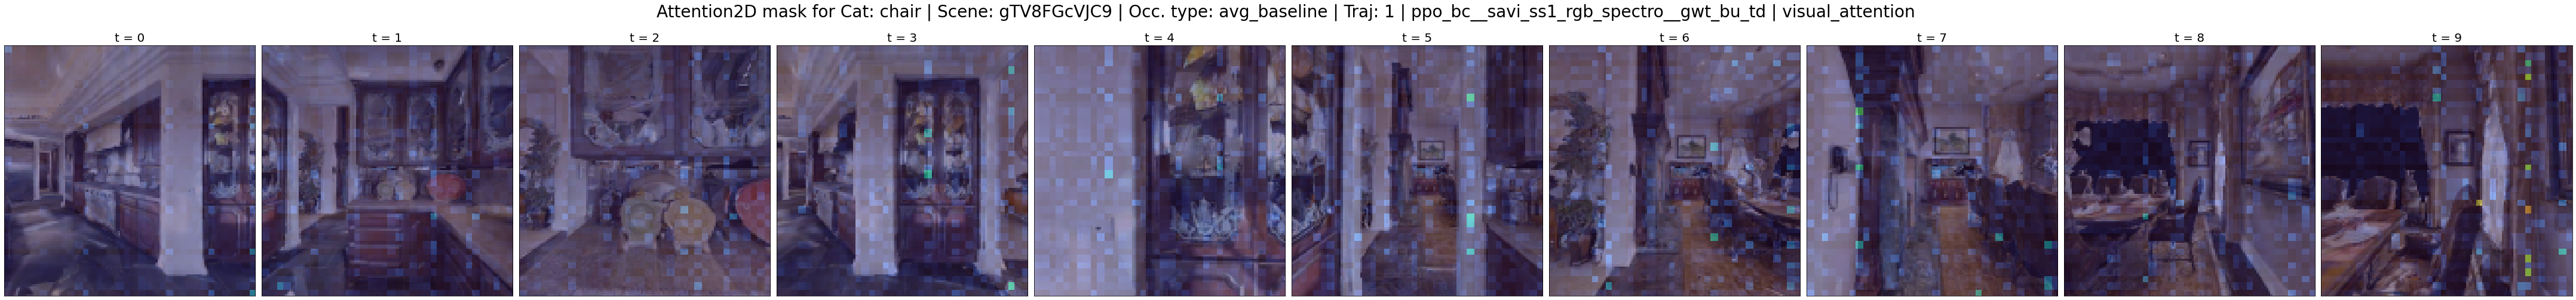

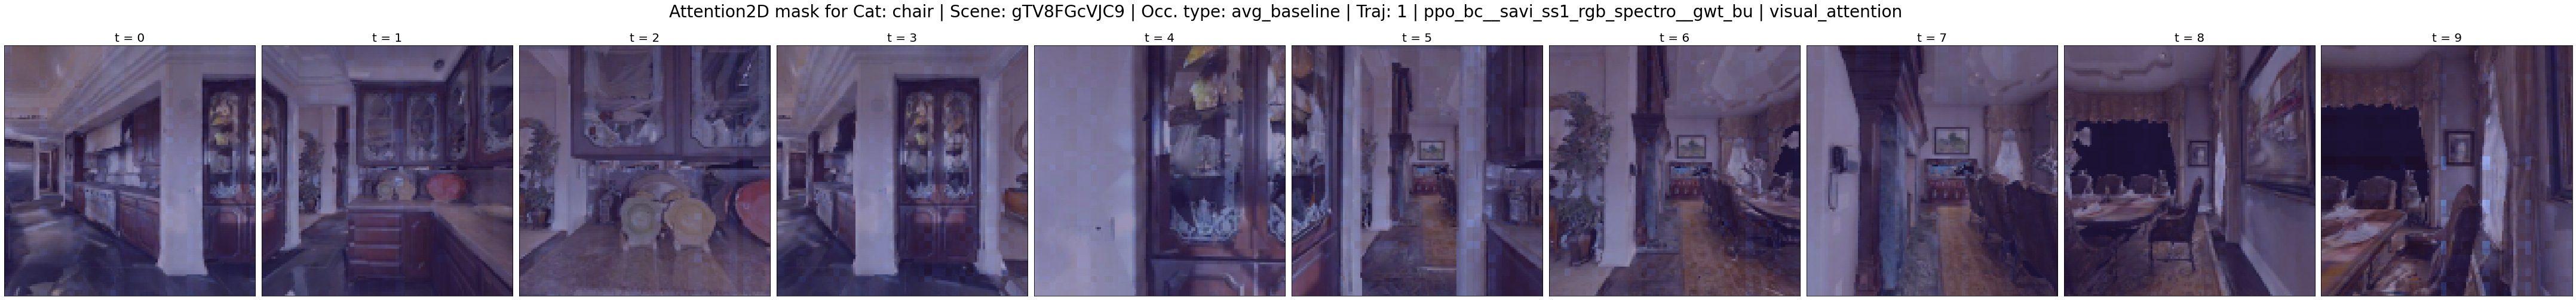

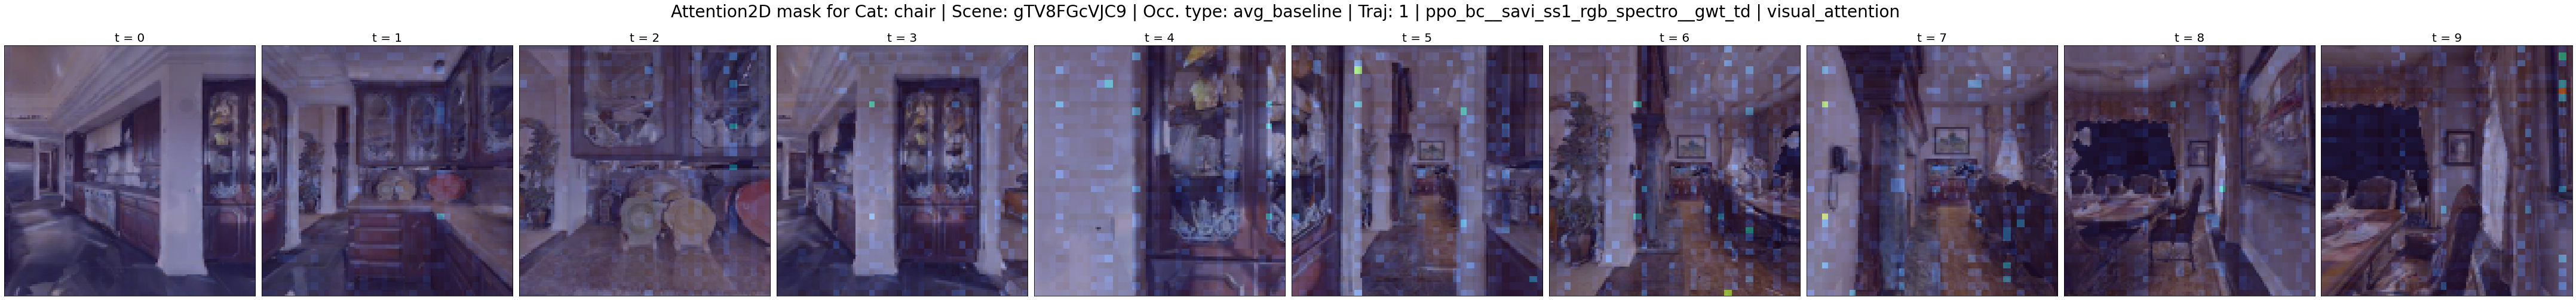

In [52]:
# Placeholder for all saliencyes
ALL_FEATS_ATT_ANALYSIS = {
    k: {
        kk: {
            kkk: {
                agent_variant: {} \
                    for agent_variant in MODEL_VARIANTS_TO_AGENTMODEL.keys()
            } for kkk in range(len(vv))
        } for kk, vv in v.items()
    } for k, v in cats_scenes_trajs_dict.items()
} # Holds all the saliencies computed

if not os.path.exists(allfeats_filename):
    for catname, cat_scenes_trajs in cats_scenes_trajs_dict.items():
        # Skip categories that are not of interest
        if catname not in CATEGORIES_OF_INTEREST:
            continue
        print(f"{catname}:")
        
        # For plot and data caching
        cat_dirname = f"{allfeats_dirname}/nn_features_data/{GEN_TIMESTAMP}/{catname}"

        for scene, scene_trajs in cat_scenes_trajs.items():
            # Skip scenes that are not of interest
            if scene not in SCENES_OF_INTEREST:
                continue
            
            # For plot and data caching
            scene_dirname = f"{cat_dirname}/{scene}"

            traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in scene_trajs]
            print(f"  {scene}: {traj_lengths}")

            for traj_idx, traj_data in enumerate(scene_trajs):
                if traj_idx not in TRAJS_OF_INTEREST:
                    continue
                print(f"    Traj {traj_idx}")

                # For plot and data caching
                traj_dirname = f"{scene_dirname}/{traj_idx}"

                # Load the current trajectory's data
                obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list = \
                    get_traj_data_by_category_scene_trajIdx(cats_scenes_trajs_dict, catname, scene, traj_idx, tensorize=True, device=dev)
                
                traj_length = len(obs_dict_list)

                for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
                    if agent_variant in ["ppo_gru__random", "ppo_pgwt__random"]:
                        # Skip irrelevant variants
                        continue
                    if agent_variant not in AGENT_VARIANTS_OF_INTEREST:
                        continue
                    print(f"      Model variant: {agent_variant}")

                    # For plot and data caching
                    agent_variant_dirname = f"/{agent_variant}"

                    agent_raw_features = {}
                    # NOTE: Do we really need to keep this in a dictionary ?
                    if agent_variant.__contains__("gru") or \
                        agent_variant.__contains__("gwt_bu_td") or \
                        agent_variant.__contains__("gwt_bu") or \
                        agent_variant.__contains__("gwt_td"):
                        agent_rnn_state = th.zeros((1, 1, args.hidden_size), device=dev)
                    elif agent_variant.__contains__("pgwt"):
                        agent_rnn_state = agent_model.state_encoder.latents.clone().repeat(1, 1, 1)

                    for t, (obs_th, done_th) in enumerate(zip(obs_dict_list, done_list)):
                        masks = 1. - done_th[:, None]

                        with th.no_grad():
                            _, _, _, _, _, _, agent_rnn_state, _ = \
                                agent_model.act(obs_th, agent_rnn_state, masks)

                        # Collecting intermediate layers results
                        for k, v in agent_model._features.items():
                            if k not in LAYERS_OF_INTEREST:
                                continue # Skip irrelevant layers
                            if k not in list(agent_raw_features.keys()):
                                agent_raw_features[k] = []
                            agent_raw_features[k].append((v[0].cpu(), v[1].cpu()) if isinstance(v, tuple) else v.cpu())
                    
                    agent_layers_features = process_analysis_feats_raw__occ_variant(agent_raw_features)
                    del agent_raw_features

                    # Compute the saliency for each intermediate layer of interest of the agent variant
                    for intermediate_layer, layer_features in agent_layers_features.items():
                        print(f"        Store features for layer: {intermediate_layer}")
                        if intermediate_layer in ["visual_attention", "audio_attention"]:
                            if agent_variant.__contains__("gwt_bu_td") or \
                                agent_variant.__contains__("gwt_bu") or \
                                agent_variant.__contains__("gwt_td"):
                                # Do nothing because we are using custom GRUCell instead of SS baselines'
                                # The latter actually returns two vectors of shape [B, H], [1, B, H] for compatiblity reasons
                                layer_features = layer_features[1]
                            else:
                                # For state encoder, tkae the first element in the tuple.
                                # layer_features = layer_features
                                pass

                        ALL_FEATS_ATT_ANALYSIS[catname][scene][traj_idx][agent_variant][intermediate_layer] = \
                            layer_features
                        
                        # Plotting upscaled attention masks on top of observations
                        fig, axes = plt.subplots(1, traj_length, figsize=(traj_length * 6, 6 + 1.5))

                        for t, obs_th in enumerate(obs_dict_list):
                            axes[t].imshow(obs_th["rgb"][0].int().cpu().numpy())
                            axes[t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
                            axes[t].set_title(f"t = {t}", fontsize=20)
                            
                            att_weights = layer_features[t]
                            upscaled_att_weights = F.interpolate(att_weights[None, :, :, :], [128, 128])[0].permute(1, 2, 0).float().cpu().numpy()
                            axes[t].imshow(upscaled_att_weights, cmap="turbo", alpha=0.5, vmin=0, vmax=1)
                            
                        fig.suptitle(f"Attention2D mask for Cat: {catname} | Scene: {scene} | Occ. type: {occ_type} | Traj: {traj_idx} | {agent_variant} | {intermediate_layer} ", fontsize=28)
                        fig.tight_layout()
                
                del obs_dict_list, done_list, target_scene_idx_list, target_category_idx_list
                th.cuda.empty_cache()

### Tests and prototypes

In [23]:
ALL_FEATS_ATT_ANALYSIS["chair"]["gTV8FGcVJC9"][1]["ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td"]["visual_attention"].shape

torch.Size([10, 1, 36, 36])

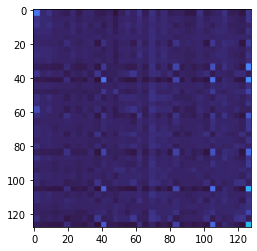

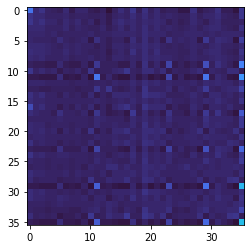

In [53]:
tmp_att_weights = ALL_FEATS_ATT_ANALYSIS["chair"]["gTV8FGcVJC9"][1]["ppo_bc__savi_ss1_rgb_spectro__gwt_bu_td"]["visual_attention"][0]
tmp_att_weights.shape # [1, 36, 36]
att_mask = F.interpolate(tmp_att_weights[None, :, :, :], [128, 128], mode="nearest", antialias=False)[0]
att_mask.shape
fig, ax = plt.subplots(1,1)
ax.imshow(att_mask.permute(1, 2, 0).cpu().numpy(), cmap="turbo", vmin=0, vmax=1)

fig, ax = plt.subplots(1,1)
ax.imshow(tmp_att_weights.permute(1, 2, 0).cpu().numpy(), cmap="turbo", vmin=0, vmax=1)

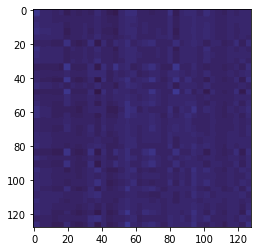

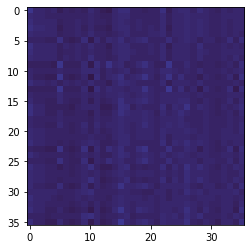

In [54]:
tmp_att_weights = ALL_FEATS_ATT_ANALYSIS["chair"]["gTV8FGcVJC9"][1]["ppo_bc__savi_ss1_rgb_spectro__gwt_bu"]["visual_attention"][0]
tmp_att_weights.shape # [1, 36, 36]
att_mask = F.interpolate(tmp_att_weights[None, :, :, :], [128, 128], mode="nearest", antialias=False)[0]
att_mask.shape
fig, ax = plt.subplots(1,1)
ax.imshow(att_mask.permute(1, 2, 0).cpu().numpy(), cmap="turbo", vmin=0, vmax=1)

fig, ax = plt.subplots(1,1)
ax.imshow(tmp_att_weights.permute(1, 2, 0).cpu().numpy(), cmap="turbo", vmin=0, vmax=1)

# Manual correlation computation for different neuron ablations

In [ ]:
# Reading cached values
# TODO: check that folder FEATURES_CACHE_DIRNAME exists. If it does, read cached data
# otherwise, prepare to create a new set
CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES = {}

for catname in CATEGORIES_OF_INTEREST:
    if catname not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES.keys():
        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname] = {}
    
    for scene in SCENES_OF_INTEREST:
        if scene not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname].keys():
            CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene] = {}
        
        for traj_idx in TRAJ_INDICES:
            if traj_idx not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene].keys():
                CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx] = {}
            
            # TODO: also read metadata about the trajectory, i.e. target_{category, scene}_idx_likst

            for ablation_type in ABLATIONS_OF_INTEREST:
                if ablation_type not in CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx].keys():
                    CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx][ablation_type] = {}

                # TODO: fix the caching itself, where the content of "features" still has the different agent variants
                for agent_variant in AGENTVARIANTS_OF_INTEREST:
                    agent_variant_features_filepath = f"{CACHE_DIRNAME}/{catname}/{scene}/{traj_idx}/{ablation_type}/{agent_variant}/features.bz2"
                    with open(agent_variant_features_filepath, "rb") as f:
                        CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES[catname][scene][traj_idx][ablation_type][agent_variant] = cpkl.load(f)[agent_variant]

In [ ]:
# State features for the whole trajecotyr
default__state_encoder__activations = \
    np.array(CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES["chair"]["D7N2EKCX4Sj"][0]["default"]["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]) ; default__state_encoder__activations.shape
vision_only__state_encoder__activations = \
    np.array(CAT_SCENE_TRAJS_ABLATION_AGENT_FEATURES["chair"]["D7N2EKCX4Sj"][0]["vision"]["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]) ; vision_only__state_encoder__activations.shape

# Manual computation of correlation
# TODO: turns this into an function later
x = default__state_encoder__activations[0]
y = vision_only__state_encoder__activations[0]

# x = np.array([6, 12, 13, 17, 22, 25, 27, 29, 30, 32])
# y = np.array([45, 47, 39, 58, 68, 76, 75, 74, 78, 81])

x_mean, y_mean = np.mean(x), np.mean(y)

x_minus_x_mean = x - np.ones_like(x) * x_mean
y_minus_y_mean = y - np.ones_like(y) * y_mean

coeff1 = x_minus_x_mean * y_minus_y_mean

x_minus_x_mean__pow2 = x_minus_x_mean ** 2
y_minus_y_mean__pow2 = y_minus_y_mean ** 2

coeff1__sum = np.sum(coeff1)
x_minus_x_mean__pow2__sum = np.sum(x_minus_x_mean__pow2)
y_minus_y_mean__pow2__sum = np.sum(y_minus_y_mean__pow2)

pearson_corr = coeff1__sum / ((x_minus_x_mean__pow2__sum * y_minus_y_mean__pow2__sum) ** 0.5); pearson_corr

# Does this make sense ? 1-to-1 correlaton between each neuron


## Processing agent features for category -> scenes -> trajectories, computing sparsity, and RDMs

In [15]:
from copy import deepcopy
from rsatoolbox.rdm.rdms import RDMs
from rsatoolbox.data import average_dataset_by
from rsatoolbox.util.rdm_utils import _extract_triu_

# from sklearn import preprocessing
from scipy import spatial

In [ ]:
def _parse_input(dataset, descriptor):
    if descriptor is None:
        measurements = dataset.measurements
        desc = np.arange(measurements.shape[0])
        descriptor = 'pattern'
    else:
        measurements, desc, _ = average_dataset_by(dataset, descriptor)
    return measurements, desc, descriptor

# TODO: cosine similarity to evaluate similarity ?

def calc_rdm_cosine_dist(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([
        [
            spatial.distance.cdist(
                measurements[j][None, :], 
                measurements[k][None, :],
                "cosine")[0][0]
            for k in range(N)
        ] for j in range(N)
    ])
    
    rdm = _extract_triu_(rdm) # / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def calc_rdm_correlation_sim(dataset, descriptor=None):
    """
    calculates an RDM from an input dataset using correlation distance
    If multiple instances of the same condition are found in the dataset
    they are averaged.
    The returned value will be the similarities instead of dissimilarities

    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset

    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM

    """
    ma, desc, descriptor = _parse_input(dataset, descriptor)
    ma = ma - ma.mean(axis=1, keepdims=True)
    ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]
    rdm = np.einsum('ik,jk', ma, ma)
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='correlation',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# NOTE: all of thoes are dissimilarity metrics, so requires a 
# a receiprocal method to convert to similarity instead.
RSA_DISSIM_METRICS = {
    # "rsa_correlation": {
    #     "fn": rsatoolbox.rdm.calc_rdm_correlation,
    #     "pretty_name": "Pearson Correlation (Dissimilarity is high)",
    #     "vmin": 0, "vmax": 1
    # },
    # TODO: Similarity based on Pearson correlation seems to be bugged
    # One hint is that the computed metric is not good when the deno is 0, or the 
    # frames are very dissimilar.
    "rsa_correlation_sim": {
        "fn": calc_rdm_correlation_sim,
        "pretty_name": "Pearson Correlation (Similiarity is high)",
        "vmin": 0, "vmax": 1
    },
}

In [ ]:
# Systematic plotting for each shared intermediate layers
all_layers = []
for v in AGENT_FEATURES.values():
    all_layers.extend(v.keys())
all_layers = set(all_layers); all_layers

# Extract shared layers, and other groups of layers of interest
shared_layers = []
visual_encoder_layernames = []
audio_encoder_layernames = []
for x in all_layers:
    x_found_in_all = True
    for v in AGENT_FEATURES.values():
        if x not in v.keys():
            x_found_in_all = False
            break
    
    if x_found_in_all:
        shared_layers.append(x)
    
    if x.startswith("visual_encoder"):
        visual_encoder_layernames.append(x)
    if x.startswith("audio_encoder"):
        audio_encoder_layernames.append(x)

# Pre-compute all sparsities
# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

VARIANT_LAYERS_SPARSITIES = {k: {} for k in MODEL_VARIANTS_TO_STATEDICT_PATH.keys()}

# NOTE: manually chose the metric for the RDM computation
# DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_euclid
DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_correlation
# DISS_CALC_FN = calc_rdm_cosine_dist # Custom Cosine distance (Similarity
# DISS_CALC_FN = calc_rdm_isc # Custom 'Improved Sqrd Root' 
# DISS_CALC_FN = calc_rdm_isc 



# Placeholder for the whole RDMs for each agent varaint
# "variant" -> "layer" -> "metric" -> rdm data
VARIANTS_RDMS = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}
# Placeholder for the mean and std of the dissimilaritie for each variant
VARIANT_RDMS_MEAN_STD = {k: {kk: {} for kk in shared_layers} for k in AGENT_FEATURES.keys()}

for layername in sorted(shared_layers):
    for agent_variant, agent_variant_features in AGENT_FEATURES.items():
        variant_layer_features = agent_variant_features[layername]
        if isinstance(variant_layer_features, list):
            # If the features record for a given layer are a "list", then it is probablye al yaer
            # like the MHA state_encoder, which returns more than one output: flat state_features,
            # and the non flattented varianst: [B, NUM_LATENTS, LATENT_DIM]S. Using [0] just takes
            # the flattened version anyway, then futher flattens it over a batch ?
            variant_features = variant_layer_features[0].flatten(start_dim=1)
        else:
            # if it is not a list, then it is probably a tensor. For example the outout of an nn.Linear
            # or state features outpout by a GRU-based StateEncoder component in the agent
            variant_features = variant_layer_features.flatten(start_dim=1)

            
        variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
        
        # Compute RDM for each variant
        for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
            metric_fc = dissim_metric_data["fn"]
            # Compute the RDMs for the given agent variant
            variant_rdm = metric_fc(variant_data)
            
            # Store the RDMs for subsequent plots
            VARIANTS_RDMS[agent_variant][layername][dissm_metric] = variant_rdm

            # Pre-compute the mean and std of dissmilarities for the current layer of the current variant
            VARIANT_RDMS_MEAN_STD[agent_variant][layername][dissm_metric] = {
                "mean": np.mean(variant_rdm.dissimilarities),
                "std": np.std(variant_rdm.dissimilarities)
            }

        # Variant's layerwise sparsity
        VARIANT_LAYERS_SPARSITIES[agent_variant][layername] = compute_sparsity(variant_features)

In [ ]:
len(obs_dict_list) // 4

In [ ]:
[obs_dict_list[0]["spectrogram"].sum() for i in range(len(obs_dict_list) // 4)]

In [ ]:
# Average similarities and Sparsities all in one
"""
    This expects:
        - PPO GRU Untrained (Random)
        - PPO PGWT Untrained (Random)
        - PPO GRU RL
        - PPO PGWT RL
"""
from turtle import position
from matplotlib.gridspec import GridSpec # TODO: move to the top

N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())
# VARIANTS_COLOR_PALETTE = sns.color_palette(n_colors=N_VARIANTS)
paired_color_palette = sns.color_palette("Paired")

VARIANTS_COLOR_PALETTE_DICT = {
    "ppo_gru__random": paired_color_palette[0], # Light blue
    "ppo_pgwt__random": paired_color_palette[4], # Light red
    
    # "ppo_gru__rl__SAVi": paired_color_palette[1], # Dark blue
    # "ppo_pgwt__rl__SAVi": paired_color_palette[5] # Dark red

    # "ppo_gru__bc__SAVi": paired_color_palette[1], # Dark blue
    # "ppo_pgwt__bc__SAVi": paired_color_palette[5] # Dark red

    "ppo_bc__rgbd_spectro__gru__SAVi": paired_color_palette[1], # Dark blue
    "ppo_bc__rgbd_spectro__pgwt__SAVi": paired_color_palette[5] # Dark red    
}
VARIANTS_BAR_SHIFTING = np.linspace(-0.1, 0.1, N_VARIANTS)[::-1]
VARIANTS_BAR_SHIFTING_1 = np.linspace(-0.1, 0.1, 3)[::-1] # For the visual and audio encoders

# VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__rl__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT = ["ppo_gru__random", "ppo_bc__rgbd_spectro__gru__SAVi", "ppo_bc__rgbd_spectro__pgwt__SAVi"]
VIS_AUD_VARIANTS_TO_PLOT_PALETTE = [VARIANTS_COLOR_PALETTE_DICT[k] for k in VIS_AUD_VARIANTS_TO_PLOT]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    fig = plt.figure(figsize=(16,8))

    # Visual and audo encoder layers
    gs1 = GridSpec(2, 1, left=0.0, right=0.725, wspace=0)

    ## Video encoder layers
    vis_enc_ax = fig.add_subplot(gs1[0, 0])

    visual_encoder_layernames.sort()
    visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
    x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_variant_drms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in visual_encoder_layernames_relu_skipped]

        vis_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    vis_enc_ax.set_xlabel("Video Encoder Layers", fontsize=14)
    vis_enc_ax.xaxis.set_label_position("top")
    vis_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    vis_enc_ax.set_xticks(x)
    visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    vis_enc_ax.set_xticklabels(visual_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # vis_enc_ax.legend()

    ## Audo encoder layers
    aud_enc_ax = fig.add_subplot(gs1[1, 0])

    audio_encoder_layernames.sort()
    audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

    x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    for t, agent_variant in enumerate(VIS_AUD_VARIANTS_TO_PLOT):
        agent_variant_drms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        # Skip plotting of the visual and audio encoder layers avg similarity plotting
        if agent_variant == "ppo_pgwt__random":
            continue
        y = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
        yerr = [agent_variant_drms_mean_std_dict[lynm][dissm_metric]["std"] for lynm in audio_encoder_layernames_relu_skipped]

        aud_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING_1[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    aud_enc_ax.set_xlabel("Audio Encoder Layers", fontsize=14)
    aud_enc_ax.xaxis.set_label_position("top")
    aud_enc_ax.set_ylabel("Average Similarity", fontsize=14)
    aud_enc_ax.set_xticks(x)
    audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
    aud_enc_ax.set_xticklabels(audio_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
    # aud_enc_ax.legend()

    # State features plot
    gs2 = GridSpec(1,1, left=0.775, right=1.0, wspace=0.05)

    state_feat_ax = fig.add_subplot(gs2[0, 0])

    # for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    # for t, agent_variant in enumerate(["ppo_gru__random", "ppo_gru__rl__SAVi", "ppo_pgwt__random", "ppo_pgwt__rl__SAVi"]):
    for t, agent_variant in enumerate(["ppo_gru__random", "ppo_bc__rgbd_spectro__gru__SAVi", "ppo_pgwt__random", "ppo_bc__rgbd_spectro__pgwt__SAVi"]):
        agent_varaint_rdms_mean_std_dict = VARIANT_RDMS_MEAN_STD[agent_variant]
        y = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["mean"]
        yerr = agent_varaint_rdms_mean_std_dict["state_encoder"][dissm_metric]["std"]

        state_feat_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                    elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE_DICT[agent_variant])

    state_feat_ax.set_ylabel("Average Similarity", fontsize=14)
    # state_feat_ax.set_ylim(-0.1, 1)
    state_feat_ax.set_xticks([1])
    state_feat_ax.set_xlim(0.5, 1.5)
    state_feat_ax.legend(fontsize=15, loc="lower right")

    fig.suptitle(f"Component's layer-wise average similarity based on {dissim_metric_data['pretty_name']} metric", fontsize=18)
    # fig.tight_layout()
    fig.show()

In [ ]:
# All in one Plotn Style 3 Group by variant

## General

VARIANTS_TO_PLOT = [
    # BC variants
    "ppo_bc__rgbd_spectro__gru__SAVi",
    "ppo_bc__rgbd_spectro__pgwt__SAVi",

    # Random
    "ppo_gru__random",
    "ppo_pgwt__random",

    # # RL variants
    # "ppo_gru__rl__SAVi",
    # "ppo_pgwt__rl__SAVi",
]
VARIANTS_RMDS_TO_PLOT = {k: VARIANTS_RDMS[k] for k in VARIANTS_TO_PLOT}

N_VARIANTS = len(VARIANTS_TO_PLOT)
## Visual encoder
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

## Audio encoder
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]
audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

for dissm_metric, dissim_metric_data in RSA_DISSIM_METRICS.items():
    
    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(2, 1, left=0.78, right=0.98, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(2)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    # VMIN, VMAX = None, None
    VMIN, VMAX = 0, 1
    
    for variant_idx, agent_variant in enumerate(["ppo_gru__random", "ppo_pgwt__random"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=14)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_ylabel(f"{agent_variant_pretty}\n", fontsize=15)
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
        if variant_idx == 0:
            variant0_right_axes[variant_idx][-1].set_xlabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
            variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")

    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for Random Init. Networks", fontsize=18, y=1)
    # fig.tight_layout()
    fig.show()

    ## PPO GRU BC (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_bc__rgbd_spectro__gru__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                # variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
    
    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for {agent_variant_pretty}", fontsize=18, y=1)
    fig.show()
    ## PPO PGWT BC (SAVi)

    # THe overall figure
    fig = plt.figure(figsize=(22,10))

    n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

    # One gridspec for "randomly inited variants", "PPO GRU RL SAVi" and "PPO PGWT RL SAVi"
    ## For Random variants
    gs0_left = GridSpec(2, n_cols, left=0.0, right=0.76, wspace=0.05, hspace=0.05)
    gs0_right = GridSpec(1, 1, left=0.78, right=0.98, top=0.70, bottom=0.30, wspace=0.05, hspace=0.05)
    
    variant0_left_axes = [[fig.add_subplot(gs0_left[i, j]) for j in range(n_cols)] for i in range(2)]
    variant0_right_axes = [[fig.add_subplot(gs0_right[i, j]) for j in range(1)] for i in range(1)]

    variant0_right_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in variant0_right_axes]
    variant0_right_caxes = [d.append_axes('right', size='5%', pad=0.1) for d in variant0_right_dividers]

    for variant_idx, agent_variant in enumerate(["ppo_bc__rgbd_spectro__pgwt__SAVi"]):
        agent_variant_rdm = VARIANTS_RDMS[agent_variant]
        agent_variant_pretty = MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"]

        if variant_idx == 0:
            # Plotting visual encoder RSA
            for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[0][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[0][0], orientation='vertical')

                variant0_left_axes[0][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[0][0].set_ylabel("Visual Encoder", fontsize=15)

                variant0_left_axes[0][ax_idx].set_xlabel(f"{visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=15)
                variant0_left_axes[0][ax_idx].xaxis.set_label_position("top")

            # Plotting audio encoder RSA
            for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
                im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername][dissm_metric], ax=variant0_left_axes[1][ax_idx],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)
                # fig.colorbar(im, cax=variants_caxes[1][0], orientation='vertical')

                variant0_left_axes[1][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
                variant0_left_axes[1][0].set_ylabel("Audio Encoder", fontsize=15)
        
        # Plotting state features RSA
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"][dissm_metric], ax=variant0_right_axes[variant_idx][-1],
                                            cmap=mpl.colormaps["plasma"], vmin=VMIN, vmax=VMAX)

        variant0_right_axes[variant_idx][-1].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=15)
        
        variant0_right_axes[variant_idx][-1].set_xlabel(f"{agent_variant_pretty}\n", fontsize=15)
        variant0_right_axes[variant_idx][-1].xaxis.set_label_position("top")
        variant0_right_axes[variant_idx][-1].set_ylabel(f"State features (RNN Cell)\n", fontsize=15, position="above")
        fig.colorbar(im, cax=variant0_right_caxes[variant_idx], orientation='vertical')
    
    fig.suptitle(f"Component's Layer-wise RSA with {dissim_metric_data['pretty_name']} for {agent_variant_pretty}", fontsize=18, y=1)
    fig.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(8,6))
traj_length = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder.ca.mha"][1].shape[0]
x = np.arange(traj_length)

MOD_AXIS_TO_NAME = {0: "Audio", 1: "Vision", 2: r"Prev. state $h_{t-1}$" }
MOD_AXIS_TO_COLOR = { 0: "green", 1: "blue", 2: "grey" }

for mod_axis in range(3):
    ax.plot(x, AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder.ca.mha"][1].mean(1)[:, mod_axis],
            label=MOD_AXIS_TO_NAME[mod_axis],
            color=MOD_AXIS_TO_COLOR[mod_axis])

ax.set_ylabel("Attention weights", fontsize=15)
ax.set_xlabel("Time steps", fontsize=15)
fig.legend(fontsize=15, loc="center")
fig.suptitle("TransRNN Attention over one episode", fontsize=16)
fig.tight_layout()
fig.show()

# Frame-wise correlation between each neuron / unit of a NN component

In [ ]:
"""
    This should compute the correlation between activation of neurons across a single step / input frame.
    The idea is to see which group of neuron exhibit similar activation pattern on given a single step
    then hopefully extend it to the whole trajectory.
"""

AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"].keys()
AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0].shape
ep_length = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0].shape[0] // 4

rnn_features_0 = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0][0].view(512, 1); rnn_features_0.shape
rnn_features_0_512_1536_2048 = th.cat([AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0][i * ep_length] for i in range(4)], axis=-1); rnn_features_0_512_1536_2048.shape
# rnn_features_0_512_1536_2048 = rnn_features_0_512_1536_2048[:, None]
rnn_features_0_512_1536_2048 = rnn_features_0_512_1536_2048.view(-1, 64)

rdm_dset = rsatoolbox.data.Dataset(rnn_features_0_512_1536_2048.cpu().numpy())
# rdm = rsatoolbox.rdm.calc_rdm(rdm_dset, method="cosine")
rdm = RSA_DISSIM_METRICS["rsa_correlation_sim"]["fn"](rdm_dset) # ppo_gru__randomTODO: fix invalid data encountered
# rdm = calc_rdm_cosine_dist(rdm_dset) # ppo_gru__randomTODO: fix invalid data encountered
# rdm = rsatoolbox.rdm.sqrt_transform(rdm)
rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16,16))

In [ ]:
AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"].keys()
AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0].shape
ep_length = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0].shape[0] // 4

rnn_features_0 = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0][0].view(512, 1); rnn_features_0.shape
rnn_features_0_512_1536_2048 = th.cat([AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0][i * ep_length] for i in range(4)], axis=-1); rnn_features_0_512_1536_2048.shape
# rnn_features_0_512_1536_2048 = rnn_features_0_512_1536_2048[:, None]
rnn_features_0_512_1536_2048 = rnn_features_0_512_1536_2048.view(-1, 64)

rdm_dset = rsatoolbox.data.Dataset(rnn_features_0_512_1536_2048.cpu().numpy())
# rdm = rsatoolbox.rdm.calc_rdm(rdm_dset, method="cosine")
rdm = RSA_DISSIM_METRICS["rsa_correlation_sim"]["fn"](rdm_dset) # ppo_gru__randomTODO: fix invalid data encountered
# rdm = calc_rdm_cosine_dist(rdm_dset) # ppo_gru__randomTODO: fix invalid data encountered

# rdm = rsatoolbox.rdm.sqrt_transform(rdm)
rsatoolbox.vis.rdm_plot.show_rdm(rdm, figsize=(16,16))

# Analysis of latents based on activation values

In [ ]:
for k, v in AGENT_FEATURES.items():
    print(f"{k}: {type(v)}")
    for kk, vv in v.items():
        print(f"\t{kk}: {type(v)}")
    print("")

In [ ]:
AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0].shape # torch.Size([T, 512])
AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["visual_encoder.cnn.7"].shape # torch.Size([T, 512])
AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["audio_encoder.cnn.7"].shape # torch.Size([T, 512])

## Plot learned features for one single step

In [ ]:
# GRU network
# traj_state_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]
# traj_audio_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["audio_encoder.cnn.7"]
# traj_visual_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["visual_encoder.cnn.7"]

# PGWT network
traj_state_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["state_encoder"][0]
traj_audio_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["audio_encoder.cnn.7"]
traj_visual_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__pgwt__SAVi"]["visual_encoder.cnn.7"]

# 4 is the number of time the same traj was duplicated to make the vision / audio / nothing styyle trajectory
ep_length = traj_state_features.shape[0] // 4

N_UNITS = traj_state_features.shape[-1]
N_ROWS = 8
N_UNITS_PER_ROW = N_UNITS // 8 #N_ROWS
fig, axes = plt.subplots(N_ROWS, 1, figsize=(32, N_ROWS * 6))

tstep = 0

width = 0.2
multiplier = 0

for i, (label, traj_start) in enumerate(zip(["Default", "Vision only", "Audio only", "Zeros"],[j * ep_length for j in range(4)])):
    offset = width * multiplier

    for r in range(N_ROWS):
        x = np.arange(N_UNITS_PER_ROW)
        x_ticks = np.arange(N_UNITS_PER_ROW)
        # x_ticklabels = np.arange((r * N_UNITS_PER_ROW), ((r+1) * N_UNITS_PER_ROW))
        x_ticklabels = np.arange(N_UNITS_PER_ROW)
        # x_ticks = np.arange(r * N_UNITS_PER_ROW, (r+1) * N_UNITS_PER_ROW)
        measurements = traj_state_features[traj_start + tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
        # measurements = traj_visual_features[traj_start + tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
        axes[r].bar(x + offset, measurements, width, label=label)
        axes[r].set_xticks(x + width, x_ticklabels)
        axes[r].set_ylabel(f"Latent vector {r}")
        # axes[r].set_xticklabels(x_ticklabels) # Confusing
    
    multiplier += 1

axes[0].set_xlabel(f"state_encoder: t = {tstep}", position="top", fontsize=18)
axes[0].xaxis.set_label_position('top')
axes[0].legend(fontsize=18)
# fig.legend()
fig.set_facecolor("white")
fig.show()

In [ ]:
# GRU network
traj_state_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]
traj_audio_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["audio_encoder.cnn.7"]
traj_visual_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["visual_encoder.cnn.7"]

# 4 is the number of time the same traj was duplicated to make the vision / audio / nothing styyle trajectory
ep_length = traj_state_features.shape[0] // 4

N_UNITS = traj_state_features.shape[-1]
N_ROWS = 8
N_UNITS_PER_ROW = N_UNITS // 8 #N_ROWS
fig, axes = plt.subplots(N_ROWS, 1, figsize=(32, N_ROWS * 6))

tstep = 0

width = 0.2
multiplier = 0

for i, (label, traj_start) in enumerate(zip(["Default", "Vision only", "Audio only", "Zeros"],[j * ep_length for j in range(4)])):
    offset = width * multiplier

    for r in range(N_ROWS):
        x = np.arange(N_UNITS_PER_ROW)
        x_ticks = np.arange(N_UNITS_PER_ROW)
        # x_ticklabels = np.arange((r * N_UNITS_PER_ROW), ((r+1) * N_UNITS_PER_ROW))
        x_ticklabels = np.arange(N_UNITS_PER_ROW)
        # x_ticks = np.arange(r * N_UNITS_PER_ROW, (r+1) * N_UNITS_PER_ROW)
        measurements = traj_state_features[traj_start + tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
        # measurements = traj_visual_features[traj_start + tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
        axes[r].bar(x + offset, measurements, width, label=label)
        axes[r].set_xticks(x + width, x_ticklabels)
        axes[r].set_ylabel(f"Latent vector {r}")
        # axes[r].set_xticklabels(x_ticklabels) # Confusing
    
    multiplier += 1

axes[0].set_xlabel(f"state_encoder: t = {tstep}", position="top", fontsize=18)
axes[0].xaxis.set_label_position('top')
axes[0].legend(fontsize=18)
# fig.legend()
fig.set_facecolor("white")
fig.show()


## Plot learned features for one single step, but dupped trajectories

In [ ]:
# ep_length = 12
# traj_state_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]
# traj_audio_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["audio_encoder.cnn.7"]
# traj_visual_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["visual_encoder.cnn.7"]

# N_UNITS = traj_state_features.shape[-1]
# N_ROWS = 8
# N_UNITS_PER_ROW = N_UNITS // N_ROWS
# fig, axes = plt.subplots(8, 1, figsize=(16, 8 * 3))

# tstep = 0
# # fig.suptitle(f"state_encoder: t= {tstep}", fontsize=32)

# for r in range(N_ROWS):
#     x = np.arange(N_UNITS_PER_ROW)
#     x_ticks = np.arange(N_UNITS_PER_ROW)
#     x_ticklabels = np.arange((r * N_UNITS_PER_ROW), ((r+1) * N_UNITS_PER_ROW))
#     # x_ticks = np.arange(r * N_UNITS_PER_ROW, (r+1) * N_UNITS_PER_ROW)
#     measurements = traj_state_features[tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
#     axes[r].bar(x, measurements)
#     axes[r].set_xticks(x_ticks)
#     axes[r].set_ylabel(f"Latent vector {r}")
#     # axes[r].set_xticklabels(x_ticklabels) # Confusing

# axes[0].set_xlabel(f"state_encoder: t = {tstep}", position="top", fontsize=18)
# axes[0].xaxis.set_label_position('top')
# fig.set_facecolor("white")
# fig.show()

In [ ]:
# ep_length = 12
# traj_state_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["state_encoder"][0]
# traj_audio_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["audio_encoder.cnn.7"]
# traj_visual_features = AGENT_FEATURES["ppo_bc__rgbd_spectro__gru__SAVi"]["visual_encoder.cnn.7"]

# N_UNITS = traj_state_features.shape[-1]
# N_ROWS = 8
# N_UNITS_PER_ROW = N_UNITS // N_ROWS
# fig, axes = plt.subplots(8, 1, figsize=(16, 8 * 3))

# tstep = 12
# # fig.suptitle(f"state_encoder: t= {tstep}", fontsize=32)

# for r in range(N_ROWS):
#     x = np.arange(N_UNITS_PER_ROW)
#     x_ticks = np.arange(N_UNITS_PER_ROW)
#     x_ticklabels = np.arange((r * N_UNITS_PER_ROW), ((r+1) * N_UNITS_PER_ROW))
#     # x_ticks = np.arange(r * N_UNITS_PER_ROW, (r+1) * N_UNITS_PER_ROW)
#     measurements = traj_state_features[tstep, (r * N_UNITS_PER_ROW):((r+1) * N_UNITS_PER_ROW)]
#     axes[r].bar(x, measurements)
#     axes[r].set_xticks(x_ticks)
#     axes[r].set_ylabel(f"Latent vector {r}")
#     # axes[r].set_xticklabels(x_ticklabels) # Confusing

# axes[0].set_xlabel(f"state_encoder: t = {tstep}", position="top", fontsize=18)
# axes[0].xaxis.set_label_position('top')
# fig.set_facecolor("white")
# fig.show()

# Analazying probe accuracy accross a trajectory

In [ ]:
# Configure the device for analysis: cpu by default, might to go GPU later for large samples
# device = th.device("cpu")

# Path to probe weightss
PROBE_EXPLOGS_DIRPATH = "/home/rousslan/random/rl/exp-logs/ss-hab-bc-probing"
# TODO: add metadat such as pretty names ?
PROBE_EXPNAMES = {
    ## Random networks
    # "ppo_gru__random": "ppo_gru__random__fixTB_seed_111__2023_06_15_14_31_22_496922.musashi",
    # "ppo_pgwt__random": "ppo_pgwt__random__fixTB_seed_111__2023_06_15_14_31_20_984612.musashi",
    ## BC trained networks
    # "ppo_bc__rgbd_spectro__gru__SAVi": "ppo_bc__rgbd_spectro__gru__SAVi__fixTB_seed_111__2023_06_15_14_31_22_548789.musashi",
    # "ppo_bc__rgbd_spectro__pgwt__SAVi": "ppo_bc__rgbd_spectro__pgwt__SAVi__fixTB_seed_111__2023_06_15_14_31_20_957612.musashi",

    ## BC trained networks over RGB + Spectrogram
    ### Single layer linear probe, most basic setting
    # "ppo_bc__rgbd_spectro__gru__SAVi": "ppo_bc__rgb_spectro__gru__SAVi__9990001__n_mb_50_seed_111__2023_06_21_18_43_34_520551.Max",
    # "ppo_bc__rgbd_spectro__pgwt__SAVi": "ppo_bc__rgb_spectro__pgwt__SAVi__9990001__n_mb_50_seed_111__2023_06_21_18_43_33_229972.Max",

    ### Probe depth = 2; probe hid size 1024
    "ppo_bc__rgbd_spectro__gru__SAVi": "ppo_bc__rgb_spectro__gru__SAVi__9990001__n_mb_50__prb_dpth_2_hsize_1024_seed_111__2023_06_22_16_57_49_243803.musashi",
    "ppo_bc__rgbd_spectro__pgwt__SAVi": "ppo_bc__rgb_spectro__pgwt__SAVi__9990001__n_mb_50__prb_dpth_2_hsize_1024_seed_111__2023_06_22_16_57_46_228058.musashi"
}

# NOTE:Override the probe config appropriately
### Probe depth = 2; probe hid size 1024
args.probe_depth = 2
args.probe_hid_size = 1024
args.probe_bias = False

# Loading the probe data
# Scene list for probe target label generation
SCENES = list(dataset_statistics["scene_counts"].keys())
CATEGORIES = list(dataset_statistics["category_counts"].keys())

N_SCENES = len(SCENES)
N_CATEGORIES = len(CATEGORIES)

# Define the target of probing
## "category" -> how easy to predict category based on the learned features / inputs
## "scene" -> how easy to predict scene based on the learned features / inputs
PROBING_TARGETS = {}
for probe_target in args.probing_targets:
    if probe_target == "category":
        PROBING_TARGETS["category"] = {}
        PROBING_TARGETS["category"]["n_classes"] = N_CATEGORIES
    elif probe_target == "scene":
        PROBING_TARGETS["scene"] = {}
        PROBING_TARGETS["scene"]["n_classes"] = N_SCENES

# Define which fields of an agent to use for the probes
PROBING_INPUTS = args.probing_inputs

# Class for a generic linear probe network
class GenericProbeNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, depth=1, hid_size=512, bias=False):
        super().__init__()
        assert depth >= 1, "Probe not deep enough: {depth}"
            
        hiddens = [hid_size for _ in range(depth)]
        network = []
        for h0, h1 in zip([input_dim, *hiddens[:-1]], [*hiddens[1:], output_dim]):
            network.append(nn.Linear(h0, h1, bias=bias))
            network.append(nn.ReLU())
        network.pop()
            
        self.network = nn.Sequential(*network)
    
    def forward(self, x):
        return self.network(x)

# Instantiating probes
PROBES_METADATA = {}
for probe_target_name, probe_target_info in PROBING_TARGETS.items():
    if probe_target_name not in PROBES_METADATA.keys():
        PROBES_METADATA[probe_target_name] = {}
    for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???

        if probe_input not in PROBES_METADATA[probe_target_name].keys():
            PROBES_METADATA[probe_target_name][probe_input] = {}

        # TODO: make the probe's input dim adapt to what will actually be probed.
        PROBES_METADATA[probe_target_name][probe_input]["probe_input_dim"] = 512
        PROBES_METADATA[probe_target_name][probe_input]["probe_output_dim"] = probe_target_info["n_classes"]

# Dictionary that will holds the probe networks and their optimizers
AGENT_VARIANTS_PROBES = {}
for agent_variant, agent_probe_explogname in PROBE_EXPNAMES.items():

    PROBES = copy.deepcopy(PROBES_METADATA)
    for probe_target_name, probe_target_info in PROBING_TARGETS.items():
        for probe_input in PROBING_INPUTS: # NOTE: maybe switch order with the MODEL_VARIANTS ???
            probe_input_dim = PROBES[probe_target_name][probe_input]["probe_input_dim"]
            probe_output_dim = PROBES[probe_target_name][probe_input]["probe_output_dim"]

            probe_network = GenericProbeNetwork(probe_input_dim, probe_output_dim, depth=args.probe_depth, hid_size=args.probe_hid_size, bias=args.probe_bias).to(dev)

            # Load the trained weights of the probe
            probe_weight_savepath = f"{PROBE_EXPLOGS_DIRPATH}/{agent_probe_explogname}/models/{probe_target_name}__{probe_input}__probe.pth"
            if agent_variant in ["ppo_gru__random", "ppo_pgwt__random"]:
                probe_state_dict = th.load(probe_weight_savepath)() # TODO: retrain proper ppo_XXX_random baseline that store the state dict instead of fn..
            else:
                probe_state_dict = th.load(probe_weight_savepath)
            
            probe_network.load_state_dict(probe_state_dict)

            PROBES[probe_target_name][probe_input]["probe_network"] = probe_network
            PROBES[probe_target_name][probe_input]["agent"] = agent_variant

    AGENT_VARIANTS_PROBES[agent_variant] = PROBES

In [ ]:
ep_length = len(traj_state_features) // 4
ep_state_features = traj_state_features[:ep_length]
ep_visual_features = traj_visual_features[:ep_length]
ep_audio_features = traj_audio_features[:ep_length]
len(ep_state_features), len(ep_visual_features), len(ep_audio_features) # should the the same

In [ ]:
PROBING_INPUTS

In [ ]:
i = 0
# chair_D7N2EKCX4Sj__traj_1__modality_ablated__obs_dict_list[1].keys()
chair_D7N2EKCX4Sj__traj_1__target_scene_idx_list
chair_D7N2EKCX4Sj__traj_1__target_category_idx_list

In [ ]:
# compute accuracies based on state features
EP_AGENT_FEATURES = {
    "state_encoder": ep_state_features,
    "visual_encoder.cnn.7": ep_visual_features,
    "audio_encoder.cnn.7": ep_audio_features
}
# TODO: make this part more systematic, reduce the likelihood of error due to arbitrary cell execution
EP_TARGETS = {
    "category": th.Tensor(np.array(chair_D7N2EKCX4Sj__traj_1__target_category_idx_list, dtype=np.uint8)).to(dev),
    "scene": th.Tensor(np.array(chair_D7N2EKCX4Sj__traj_1__target_scene_idx_list, dtype=np.uint8)).to(dev)
}

PROBING_RESULTS = {}
for agent_variant, agent_probes in AGENT_VARIANTS_PROBES.items():
    PROBING_RESULTS[agent_variant] = {}

    for probe_target_name, probe_target_info in agent_probes.items():
        PROBING_RESULTS[agent_variant][probe_target_name] = {}

        for probe_input, probe_data in probe_target_info.items(): # NOTE: maybe switch order with the MODEL_VARIANTS ???
            
            probe_input_data = AGENT_FEATURES[agent_variant]["state_encoder"][0]
            
            probe_input_data = EP_AGENT_FEATURES[probe_input]
            with th.no_grad():
                probe_logits = probe_data["probe_network"](probe_input_data)
            probe_targets = EP_TARGETS[probe_target_name]

            probe_probs = F.softmax(probe_logits, dim=1)
            # probe_correct_prob = [[probe_probs[t][idx] for idx in probe_targets.long()] for t in range(ep_length)]
            # TODO: one liner
            probe_correct_indices = []
            probe_correct_prob = []
            for t in range(ep_length):
                correct_target_idx = probe_targets.long().cpu().numpy()[t]
                probe_correct_prob.append(probe_probs[t][correct_target_idx])
                probe_correct_indices.append(correct_target_idx)
            probe_correct_prob = np.array(probe_correct_prob, dtype=np.float32)

            # probe_correct_prob = th.gather(probe_probs, 1, probe_targets.long().reshape(-1, 1)).view(-1)
            probe_accuracies = (probe_probs.argmax(1) == probe_targets).float()
            probs_colors = []
            for t in range(len(probe_correct_indices)):
                probs_colors.append(["blue" if i == probe_correct_indices[t] else "grey" for i in range(probe_probs.shape[-1])])

            # Store for later analysis
            PROBING_RESULTS[agent_variant][probe_target_name][probe_input] = {
                "accuracies": probe_accuracies.cpu().numpy(),
                "correct_prob": probe_correct_prob,
                "probs": probe_probs.cpu().numpy(),
                "correct_indices": probe_correct_indices,
                "probs_colors": probs_colors
            }


In [ ]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
x = np.arange(ep_length)
ax.bar(x, PROBING_RESULTS["ppo_bc__rgbd_spectro__pgwt__SAVi"]["category"]["state_encoder"]["correct_prob"])

fig.set_facecolor("white")
fig.show()

fig, ax = plt.subplots(1,1, figsize=(4,4))
x = np.arange(ep_length)
ax.bar(x, PROBING_RESULTS["ppo_bc__rgbd_spectro__pgwt__SAVi"]["category"]["visual_encoder.cnn.7"]["correct_prob"])

fig.set_facecolor("white")
fig.show()

fig, ax = plt.subplots(1,1, figsize=(4,4))
x = np.arange(ep_length)
ax.bar(x, PROBING_RESULTS["ppo_bc__rgbd_spectro__pgwt__SAVi"]["category"]["audio_encoder.cnn.7"]["correct_prob"])

fig.set_facecolor("white")
fig.show()


In [ ]:
# Plot the accuracies for an episode, with focus on category
for agent_variant, agent_probe_results in PROBING_RESULTS.items():
    fig, axes = plt.subplots(5, ep_length, figsize=(18 * 4, 2 * 4 + 3 * 2))

    ## ppo_gru__rgbd_spectro__random__SAVi)
    for t, t_obs_dict in enumerate(chair_D7N2EKCX4Sj__traj_1__obs_dict_list):
        # Plot the spectrogram left (?)
        axes[0, t].imshow(th.cat([
            t_obs_dict["spectrogram"][0, :, :, 0],
            t_obs_dict["spectrogram"][0, :, :, 1]],
            1).float())
        axes[0, t].set_xlabel(f"Step {t}", fontsize=14)
        axes[0, t].xaxis.set_label_position('top')

        # Plot the picture
        axes[1, t].imshow(t_obs_dict["rgb"][0, :, :].long())
        # axes[1, t].set_xlabel(f"Step {t}")

        axes[0, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
        axes[1, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

        ## Following section will plot the single prob of the correct class
        # x = [0]
        # # Plot the prob of the correct target given : state features
        # axes[2, t].bar(x, agent_probe_results["category"]["state_encoder"]["correct_prob"][t], width=0.3)
        # axes[2, t].set_ylim(0, 1.1); axes[2, t].set_xlim(-0.5, 0.5)

        # # Plot the prob of the correct target given : state features
        # axes[3, t].bar(x, agent_probe_results["category"]["visual_encoder.cnn.7"]["correct_prob"][t], width=0.3)
        # axes[3, t].set_ylim(0, 1.1); axes[3, t].set_xlim(-0.5, 0.5)

        # # Plot the prob of the correct target given : state features
        # axes[4, t].bar(x, agent_probe_results["category"]["audio_encoder.cnn.7"]["correct_prob"][t], width=0.3)
        # axes[4, t].set_ylim(0, 1.1); axes[4, t].set_xlim(-0.5, 0.5)

        ## Following section plots all the probs at each time step then highlight the one for the correct target label
        x = np.arange(N_CATEGORIES)
        x_colors = agent_probe_results["category"]["state_encoder"]["probs_colors"][t]

        # Plot the prob of the correct target given : state features
        axes[2, t].bar(x, agent_probe_results["category"]["state_encoder"]["probs"][t], color=x_colors)
        axes[2, t].set_ylim(0, 1.1)

        # Plot the prob of the correct target given : state features
        axes[3, t].bar(x, agent_probe_results["category"]["visual_encoder.cnn.7"]["probs"][t], color=x_colors)
        axes[3, t].set_ylim(0, 1.1)

        # Plot the prob of the correct target given : state features
        axes[4, t].bar(x, agent_probe_results["category"]["audio_encoder.cnn.7"]["probs"][t], color=x_colors)
        axes[4, t].set_ylim(0, 1.1)
    
    axes[2, 0].set_ylabel(f"RNN feats.", fontsize=18)
    axes[3, 0].set_ylabel(f"Visual feats.", fontsize=18)
    axes[4, 0].set_ylabel(f"Audio feats.", fontsize=18)

    fig.suptitle(f"Category: chair | Step-wise probing: {agent_variant}", fontsize=24)
    fig.set_facecolor("white")
    fig.tight_layout()
    fig.show()

In [ ]:
# Plot the accuracies for an episode, with focus on category
for agent_variant, agent_probe_results in PROBING_RESULTS.items():
    fig, axes = plt.subplots(5, ep_length, figsize=(18 * 4, 2 * 4 + 3 * 2))

    ## ppo_gru__rgbd_spectro__random__SAVi)
    for t, t_obs_dict in enumerate(chair_D7N2EKCX4Sj__traj_1__obs_dict_list):
        # Plot the spectrogram left (?)
        axes[0, t].imshow(th.cat([
            t_obs_dict["spectrogram"][0, :, :, 0],
            t_obs_dict["spectrogram"][0, :, :, 1]],
            1).float())
        axes[0, t].set_xlabel(f"Step {t}", fontsize=14)
        axes[0, t].xaxis.set_label_position('top')

        # Plot the picture
        axes[1, t].imshow(t_obs_dict["rgb"][0, :, :].long())
        # axes[1, t].set_xlabel(f"Step {t}")

        axes[0, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
        axes[1, t].tick_params(axis="both", which="both", bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
        
        ## Following section will plot the single prob of the correct class
        # x = [0]
        # Plot the prob of the correct target given : state features
        # axes[2, t].bar(x, agent_probe_results["scene"]["state_encoder"]["correct_prob"][t], width=0.3)
        # axes[2, t].set_ylim(0, 1.1); axes[2, t].set_xlim(-0.5, 0.5)

        # # Plot the prob of the correct target given : state features
        # axes[3, t].bar(x, agent_probe_results["scene"]["visual_encoder.cnn.7"]["correct_prob"][t], width=0.3)
        # axes[3, t].set_ylim(0, 1.1); axes[3, t].set_xlim(-0.5, 0.5)

        # # Plot the prob of the correct target given : state features
        # axes[4, t].bar(x, agent_probe_results["scene"]["audio_encoder.cnn.7"]["correct_prob"][t], width=0.3)
        # axes[4, t].set_ylim(0, 1.1); axes[4, t].set_xlim(-0.5, 0.5)

        ## Following section plots all the probs at each time step then highlight the one for the correct target label
        x = np.arange(N_SCENES)
        x_colors = agent_probe_results["scene"]["state_encoder"]["probs_colors"][t]

        # Plot the prob of the correct target given : state features
        axes[2, t].bar(x, agent_probe_results["scene"]["state_encoder"]["probs"][t], color=x_colors)
        axes[2, t].set_ylim(0, 1.1)

        # Plot the prob of the correct target given : state features
        axes[3, t].bar(x, agent_probe_results["scene"]["visual_encoder.cnn.7"]["probs"][t], color=x_colors)
        axes[3, t].set_ylim(0, 1.1)

        # Plot the prob of the correct target given : state features
        axes[4, t].bar(x, agent_probe_results["scene"]["audio_encoder.cnn.7"]["probs"][t], color=x_colors)
        axes[4, t].set_ylim(0, 1.1)
    
    axes[2, 0].set_ylabel(f"RNN feats.", fontsize=18)
    axes[3, 0].set_ylabel(f"Visual feats.", fontsize=18)
    axes[4, 0].set_ylabel(f"Audio feats.", fontsize=18)

    fig.suptitle(f"Scene: XXXXX | Step-wise probing: {agent_variant}", fontsize=24)
    fig.set_facecolor("white")
    fig.tight_layout()
    fig.show()

# Analyzing the GRU and TransRNN latents through plots, grouped by scene / category

In [ ]:
# More detailed breakdown of the trajectories per categories then scenes
SCENES_OF_INTEREST = []
for scene, scene_cats_trajs in scenes_cats_trajs_dict.items():
    print(f"{scene}")
    for cat, cat_trajs in scene_cats_trajs.items():
        traj_lengths = [len(traj_data["edd"]["done_list"]) for traj_data in cat_trajs]
        print(f"\t{cat}: {traj_lengths}")
    print("")

# UMAP clustering of raw RGB obs following scene and categories

In [ ]:
chair_allscenes_alltrajs_obs_dict_list, _, target_scene_idx_list, target_category_idx_list = \
    get_traj_data_by_category(cats_scenes_trajs_dict, "chair", tensorize=False)
# The following three should all be equal: one target for scene / category for each step
len(chair_allscenes_alltrajs_obs_dict_list), len(target_scene_idx_list), len(target_category_idx_list)

In [ ]:
chair_allscenes_alltrajs_obs_rgb_list = np.array(
    [chair_allscenes_alltrajs_obs_dict_list[t]["rgb"] for t in range(len(chair_allscenes_alltrajs_obs_dict_list))])
chair_allscenes_alltrajs_obs_rgb_list.shape # [TT, H, W, C]

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(chair_allscenes_alltrajs_obs_rgb_list.reshape(-1, 128 * 128 * 3))

In [ ]:
# Plot clusters by scene
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, c=target_scene_idx_list, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(M+1)-0.5)
cbar.set_ticks(np.arange(M))
cbar.set_ticklabels(TARGET_SCENE_LIST)
fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on scenes", fontsize=18)
fig.show()

In [ ]:
D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list, \
D7N2EKCX4Sj_allcats_alltrajs_done_list, \
D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list, \
D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list = \
        get_traj_data_by_scene(scenes_cats_trajs_dict, "D7N2EKCX4Sj", tensorize=False)
# The following three should all be equal: one target for scene / category for each step
len(D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_scene_idx_list), len(D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list)

In [ ]:
D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list = np.array(
    [D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list[t]["rgb"] for t in range(len(D7N2EKCX4Sj_allcats_alltrajs_obs_dict_list))])
D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list.shape # [TT, H, W, C]

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(D7N2EKCX4Sj_allcats_alltrajs_obs_rgb_list.reshape(-1, 128 * 128 * 3))

In [ ]:
# Plot clusters by categories, after filtering based on `scene`
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, c=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(C+1)-0.5)
cbar.set_ticks(np.arange(C))
cbar.set_ticklabels(TARGET_CATEGORY_LIST)
fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on categories", fontsize=18)
fig.show()

# UMAP Clustering of ANN features based on scenes and categories

## 1. Scene first

In [ ]:
# T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].shape[0]
# # T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["visual_encoder.cnn.7"].shape[0]
# # T = AGENT_FEATURES["ppo_gru__bc__SAVi"]["audio_encoder.cnn.7"].shape[0]
# fig, axes = plt.subplots(T, 1, figsize=(T * 4, 48))

# for t in range(T):
#     rnn_features = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0][t].view(8, 64)
#     axes[t].imshow(rnn_features, vmin=-1.0, vmax=1.0)
#     axes[t].set_title(f"Timestep {t}")

# fig.suptitle(f"")
# fig.show()

In [ ]:
AGENT_FEATURES.keys() # ['ppo_gru__random', 'ppo_pgwt__random', 'ppo_gru__bc__SAVi', 'ppo_pgwt__bc__SAVi']
AGENT_FEATURES["ppo_gru__bc__SAVi"].keys() # ['visual_encoder.cnn.{0,1,2,3,4,5,6,7}', 'audio_encoder.cnn.{0,1,2,3,4,5,6,7}', 'action_distribution.linear', 'critic.fc', 'state_encoder']
# AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][1] # Tuple of len 2, [0] is the [T, feat_size] vector, and [1] is [T, 1, 512] probably the current state
AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].shape # Tuple of len 2, [0] is the [T, feat_size] vector, and [1] is [T, 1, 512] probably the current state

In [ ]:
AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].min(), AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0].max()

In [ ]:
rnn_features = AGENT_FEATURES["ppo_gru__bc__SAVi"]["state_encoder"][0]; rnn_features.shape # TT x 512

In [ ]:
import umap

for n_neighbors in [2, 4, 8, 16, 32, 64]:
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    # embedding = reducer.fit_transform(rnn_features.numpy(), y=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list) # This is cheating though
    embedding = reducer.fit_transform(rnn_features.numpy())

    # Plot clusters by categories, after filtering based on `scene`
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*embedding.T, c=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(C+1)-0.5)
    cbar.set_ticks(np.arange(C))
    cbar.set_ticklabels(TARGET_CATEGORY_LIST)
    fig.suptitle(f"Clustering raw RGB embeddings; color labeling based on categories | UMAP Nghbrs: {n_neighbors}", fontsize=18)
    fig.show()

## 2. Category first

In [ ]:
import umap

for n_neighbors in [2, 4, 8, 16, 32, 64]:
    reducer = umap.UMAP(n_neighbors=n_neighbors)
    # embedding = reducer.fit_transform(rnn_features.numpy(), y=D7N2EKCX4Sj_allcats_alltrajs_target_category_idx_list) # This is cheating though
    embedding = reducer.fit_transform(rnn_features.numpy())

    # Plot clusters by categories, after filtering based on `scene`
    fig, ax = plt.subplots(1, figsize=(14, 10))
    plt.scatter(*embedding.T, c=chair_allscenes_all_traj__target_scene_idx_list, cmap='Spectral', alpha=1.0)
    plt.setp(ax, xticks=[], yticks=[])
    cbar = plt.colorbar(boundaries=np.arange(M+1)-0.5)
    cbar.set_ticks(np.arange(M))
    cbar.set_ticklabels(TARGET_SCENE_LIST)
    fig.suptitle(f"Clustering raw RGB embwouldeddings; color labeling based on scene | UMAP Nghbrs: {n_neighbors}", fontsize=18)
    fig.show()